In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib
import math
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from tqdm import tqdm

import os
import datetime

start_time = datetime.datetime.now() 
print(start_time)

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

2024-06-28 17:50:53.518264


# Ensure you have a graphics card, otherwise the training time will be excessively long

In [2]:
device = torch.device("cuda:2")
print(torch.cuda.is_available())

True


# Set fixed random seed to ensure reproducible results

In [3]:
def set_seed(seed):
    # --- Set random seed
    random.seed(seed)
    np.random.seed(seed)
    # --- Ensure consistency in hash behavior
    os.environ["PYTHONHASHSEED"] = str(seed)
    # --- Setting the workspace configuration of cuBLAS
    """
    By setting the workspace configuration of cuBLAS, 
    specific workspace sizes and algorithm combinations are ensured when running deep learning models, 
    thereby maintaining consistency of results.
    """
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    # --- Make the random numbers generated on the CPU repeatable
    torch.manual_seed(seed)
    # --- Make the random numbers generated on a single GPU repeatable
    torch.cuda.manual_seed(seed)
    # --- Make the random numbers generated on multiple GPUs repeatable
    torch.cuda.manual_seed_all(seed)
    # --- Using deterministic algorithms ensures consistency and repeatability of calculation results across different runs
    torch.use_deterministic_algorithms(True)
    # --- Set the cuDNN backend to deterministic mode to ensure the use of deterministic algorithms
    """
    Certain operations (such as convolution) produce the same result in multiple runs.
    """
    torch.backends.cudnn.deterministic = True
    # --- Disable cuDNN using non deterministic algorithms
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False

set_seed(2024)

# Define a function for calculating accuracy

In [4]:
def get_clean_acc(model, data_loader, model_device):
    model.eval()
    correct = 0
    total = 0
    
    for data, labels in data_loader:
        data, labels = data.to(model_device), labels.to(model_device)
        with torch.no_grad():
            logits = model(data)
            prediction = torch.argmax(logits, 1)
            ground_truth = labels
            total += labels.size(0)
            correct += (prediction == ground_truth).sum().item()
            
    accuracy = correct / total
    print(f"Total:{total}  Correct:{correct}  CleanAccuracy:{accuracy:.4f}")
    return accuracy

# Define a function for training the model

In [5]:
def train(model_device,
          model,
          model_optimizer, 
          train_set, validate_set,
          epochs=200,
          classes=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
         ):
    train_loss_list = []
    validate_loss_list = []
    best_acc = -np.Inf
    
    # --- Define Scheduler
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=model_optimizer, milestones=[60, 120, 180], last_epoch=0 - 1)
    
    # --- Train
    for epoch in tqdm(range(epochs)):
        train_loss = 0.0
        validate_loss = 0.0
        model.train()
        count = 0
        for dataset_train, dataset_train_labels in train_set:
            count = count + 1
            dataset_train, dataset_train_labels = dataset_train.to(model_device), dataset_train_labels.to(model_device)
            
            logits = model(dataset_train)

            model_optimizer.zero_grad()
            loss = model.forward_loss(logits, dataset_train_labels)
            loss.backward()
            model_optimizer.step()
            
            train_loss += loss.item()
            torch.cuda.empty_cache()
        train_loss_list.append(train_loss / count)
        if scheduler is not None:
            scheduler.step()
        
        # --- Validate
        model.eval()
        count = 0
        for dataset_validate, dataset_validate_labels in validate_set:
            count = count + 1
            dataset_validate, dataset_validate_labels = dataset_validate.to(model_device), dataset_validate_labels.to(model_device)

            with torch.no_grad():
                logits = model(dataset_validate)
            loss = model.forward_loss(logits, dataset_validate_labels)

            validate_loss += loss.item()
            torch.cuda.empty_cache()
        validate_loss_list.append(validate_loss / count)
        
        # --- Show results
        model.eval()
        end_time = datetime.datetime.now()
        time = end_time - start_time
        print(f"Epoch:{epoch}\nTime:{time}\nLoss:{validate_loss / count}")           
        acc = get_clean_acc(model, validate_set, model_device)
        torch.cuda.empty_cache()
        
        # --- Save best model parameters
        if not os.path.exists("./best_params/cifar10/wrn_28_10"):
            os.makedirs("./best_params/cifar10/wrn_28_10")
        if acc >= best_acc:
            path = os.path.join("./best_params/cifar10/wrn_28_10", f"wrn_28_10_params_{epoch}.pth")
            #torch.save(model.module.state_dict(), path)   # Enable during multi-GPUs training
            torch.save(model.state_dict(), path)           # Enable during single GPU training
            best_acc = acc
       
        # --- Visualize loss
        if epoch != 0:
            fig = plt.figure(figsize=(5, 5))
            x = range(0, len(validate_loss_list))
            y1 = train_loss_list
            y2 = validate_loss_list
            plt.plot(x, y1, 'bo-', label="Train Loss")
            plt.plot(x, y2, 'r--', label="Validate Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            if not os.path.exists("./best_params/cifar10/wrn_28_10/loss_curve"):
                os.makedirs("./best_params/cifar10/wrn_28_10/loss_curve")
            path = os.path.join("./best_params/cifar10/wrn_28_10/loss_curve", f"loss_curve_{epoch}.png")
            plt.savefig(path, bbox_inches='tight', dpi=500)
            plt.show()

            if not os.path.exists("./best_params/cifar10/wrn_28_10/loss_list"):
                os.makedirs("./best_params/cifar10/wrn_28_10/loss_list")
            path = os.path.join("./best_params/cifar10/wrn_28_10/loss_list", f"train_loss_list.pth")
            torch.save(train_loss_list, path)
            path = os.path.join("./best_params/cifar10/wrn_28_10/loss_list", f"validate_loss_list.pth")
            torch.save(validate_loss_list, path)

# Load the dataset

In [6]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode="edge"),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_set = torchvision.datasets.CIFAR10(root="./data",
                                         train=True,
                                         transform=transform_train,
                                         download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=1)

test_set = torchvision.datasets.CIFAR10(root="./data",
                                        train=False,
                                        transform=transform_test,
                                        download=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=1)
 
print("size=", len(train_loader))
print("size=", len(test_loader))

Files already downloaded and verified
Files already downloaded and verified
size= 1563
size= 313


# Load the model

In [7]:
from model_zoo.wide_resnet import wideresnet_28_10_cifar10
net = wideresnet_28_10_cifar10()
net = net.to(device)

# Define Optimizer

In [8]:
optimizer = torch.optim.SGD(params=net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)

# Begin to train

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch:0
Time:0:06:47.354261
Loss:1.7419882163453027


  0%|▍                                                                             | 1/200 [07:09<23:43:45, 429.27s/it]

Total:10000  Correct:3256  CleanAccuracy:0.3256
Epoch:1
Time:0:13:52.368136
Loss:1.429650493704092
Total:10000  Correct:4869  CleanAccuracy:0.4869


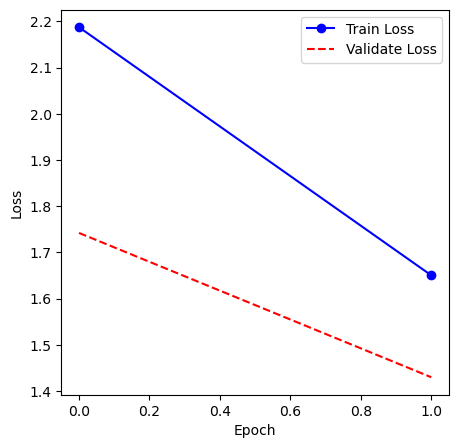

  1%|▊                                                                             | 2/200 [14:14<23:29:33, 427.14s/it]

Epoch:2
Time:0:21:00.866544
Loss:1.0757221238681685
Total:10000  Correct:6274  CleanAccuracy:0.6274


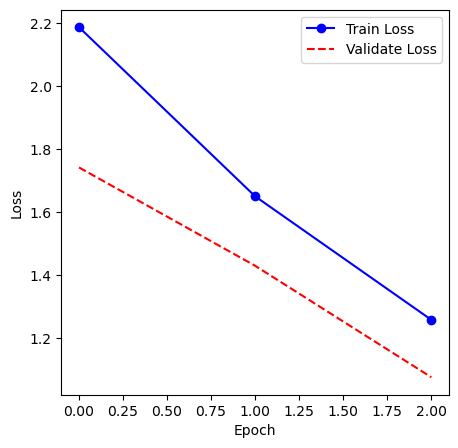

  2%|█▏                                                                            | 3/200 [21:22<23:23:32, 427.47s/it]

Epoch:3
Time:0:28:05.260926
Loss:1.0972510877127846
Total:10000  Correct:6421  CleanAccuracy:0.6421


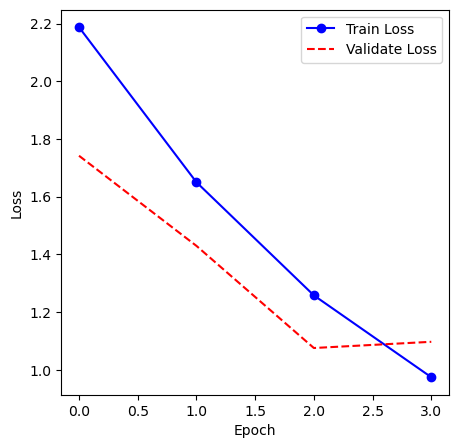

  2%|█▌                                                                            | 4/200 [28:27<23:13:26, 426.57s/it]

Epoch:4
Time:0:35:10.519261
Loss:0.7647935447220604
Total:10000  Correct:7379  CleanAccuracy:0.7379


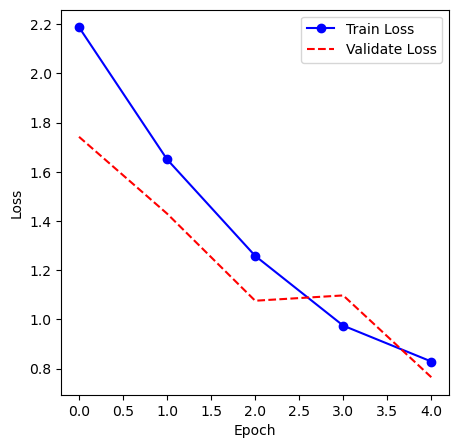

  2%|█▉                                                                            | 5/200 [35:35<23:07:14, 426.85s/it]

Epoch:5
Time:0:42:18.215738
Loss:0.871111611112619
Total:10000  Correct:7035  CleanAccuracy:0.7035


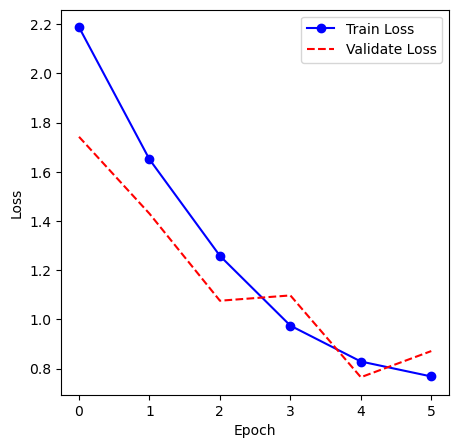

  3%|██▎                                                                           | 6/200 [42:40<22:58:39, 426.39s/it]

Epoch:6
Time:0:49:26.311306
Loss:0.8405603147543277
Total:10000  Correct:7242  CleanAccuracy:0.7242


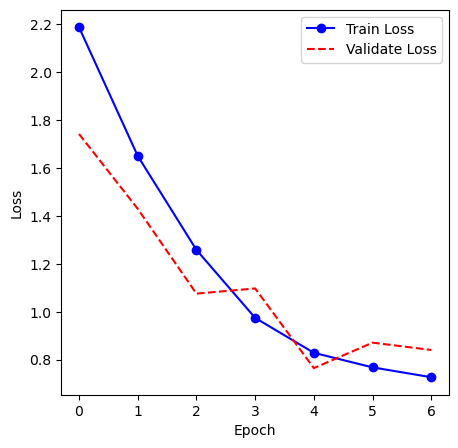

  4%|██▋                                                                           | 7/200 [49:52<22:57:04, 428.11s/it]

Epoch:7
Time:0:56:49.200547
Loss:0.8223939197132001
Total:10000  Correct:7172  CleanAccuracy:0.7172


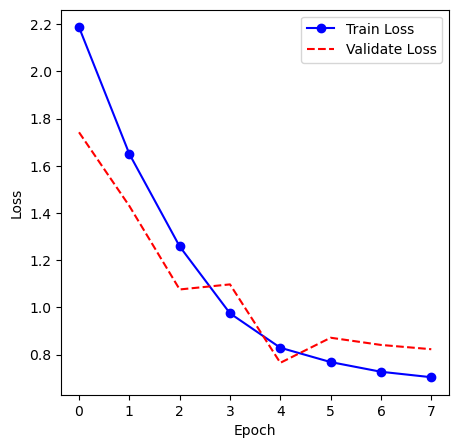

  4%|███                                                                           | 8/200 [57:11<23:00:57, 431.55s/it]

Epoch:8
Time:1:03:54.463082
Loss:0.7662246824739078
Total:10000  Correct:7473  CleanAccuracy:0.7473


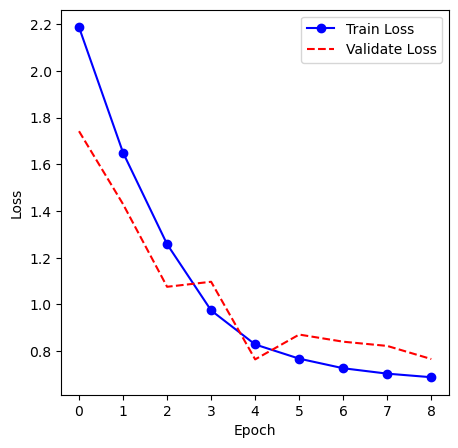

  4%|███▍                                                                        | 9/200 [1:04:21<22:52:24, 431.12s/it]

Epoch:9
Time:1:11:07.525342
Loss:0.781273370543227
Total:10000  Correct:7354  CleanAccuracy:0.7354


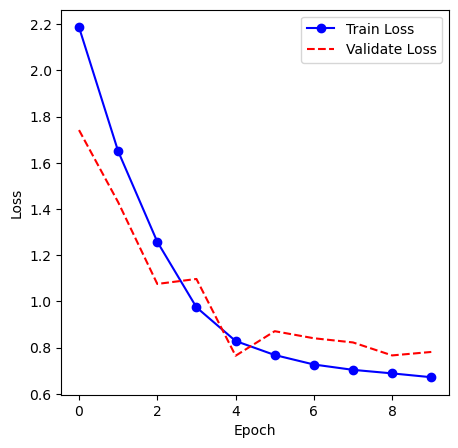

  5%|███▊                                                                       | 10/200 [1:11:32<22:45:22, 431.17s/it]

Epoch:10
Time:1:18:19.217477
Loss:0.7130044963413154
Total:10000  Correct:7509  CleanAccuracy:0.7509


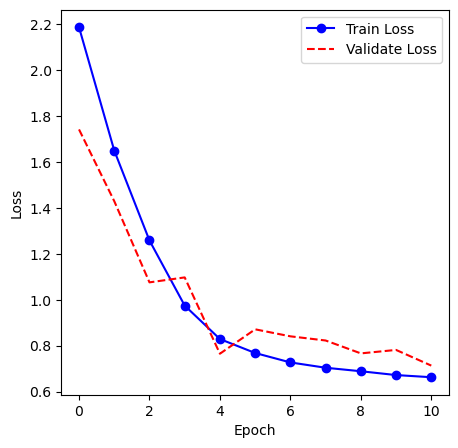

  6%|████▏                                                                      | 11/200 [1:18:44<22:38:18, 431.21s/it]

Epoch:11
Time:1:25:26.896470
Loss:0.8096047923587762
Total:10000  Correct:7249  CleanAccuracy:0.7249


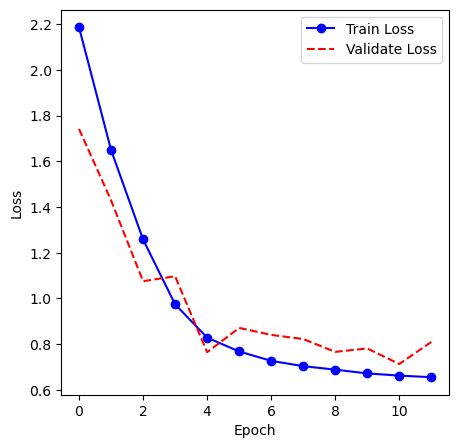

  6%|████▌                                                                      | 12/200 [1:25:51<22:26:59, 429.89s/it]

Epoch:12
Time:1:32:35.902359
Loss:0.7499152951823256
Total:10000  Correct:7503  CleanAccuracy:0.7503


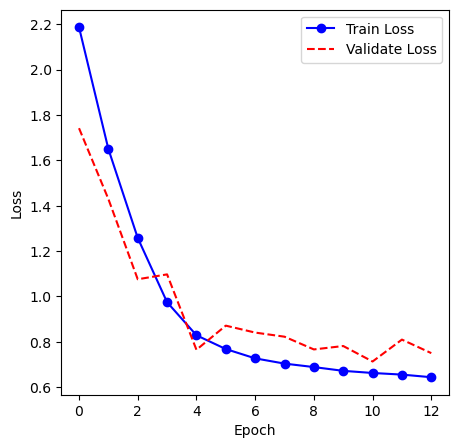

  6%|████▉                                                                      | 13/200 [1:33:03<22:22:15, 430.67s/it]

Epoch:13
Time:1:39:49.644645
Loss:0.7515576888387576
Total:10000  Correct:7402  CleanAccuracy:0.7402


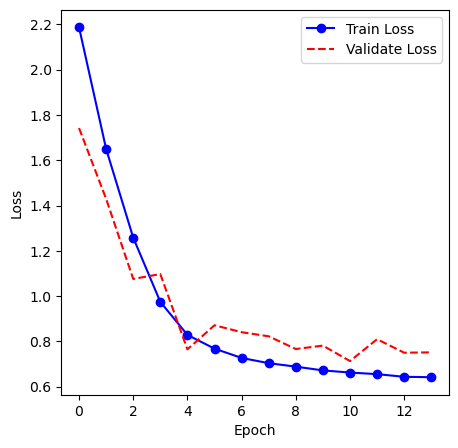

  7%|█████▎                                                                     | 14/200 [1:40:14<22:15:42, 430.88s/it]

Epoch:14
Time:1:46:58.927260
Loss:0.663560591661892
Total:10000  Correct:7683  CleanAccuracy:0.7683


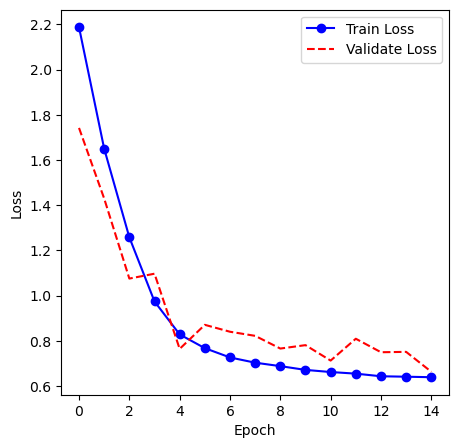

  8%|█████▋                                                                     | 15/200 [1:47:25<22:08:16, 430.79s/it]

Epoch:15
Time:1:54:10.595994
Loss:0.7234738946151429
Total:10000  Correct:7581  CleanAccuracy:0.7581


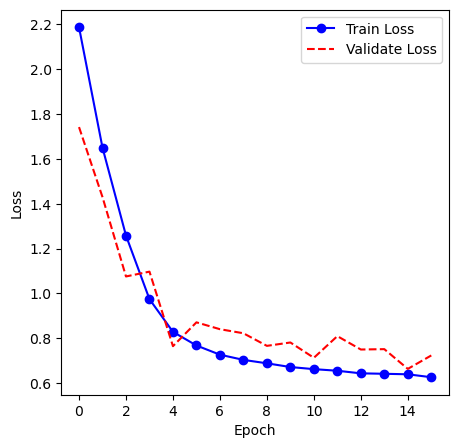

  8%|██████                                                                     | 16/200 [1:54:34<21:59:33, 430.29s/it]

Epoch:16
Time:2:01:19.100124
Loss:0.6733751329846276
Total:10000  Correct:7818  CleanAccuracy:0.7818


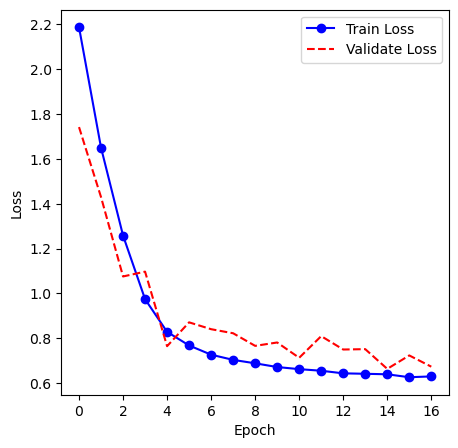

  8%|██████▍                                                                    | 17/200 [2:01:43<21:51:19, 429.94s/it]

Epoch:17
Time:2:08:30.918602
Loss:0.7615210897625445
Total:10000  Correct:7426  CleanAccuracy:0.7426


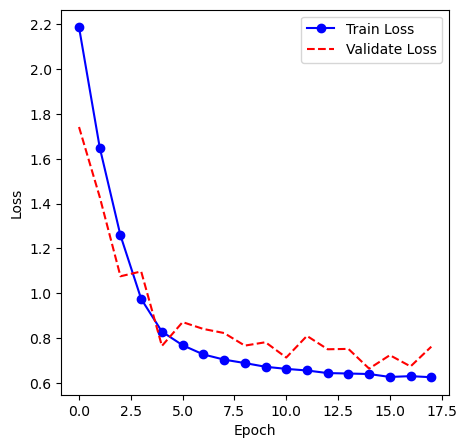

  9%|██████▊                                                                    | 18/200 [2:08:53<21:43:53, 429.85s/it]

Epoch:18
Time:2:15:35.501252
Loss:0.7833985285446666
Total:10000  Correct:7457  CleanAccuracy:0.7457


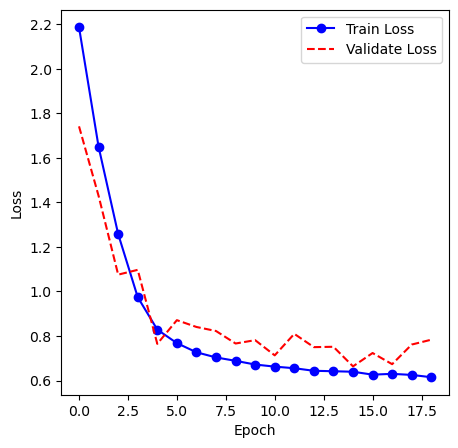

 10%|███████▏                                                                   | 19/200 [2:15:59<21:33:34, 428.81s/it]

Epoch:19
Time:2:22:41.549942
Loss:0.6140876789919485
Total:10000  Correct:7969  CleanAccuracy:0.7969


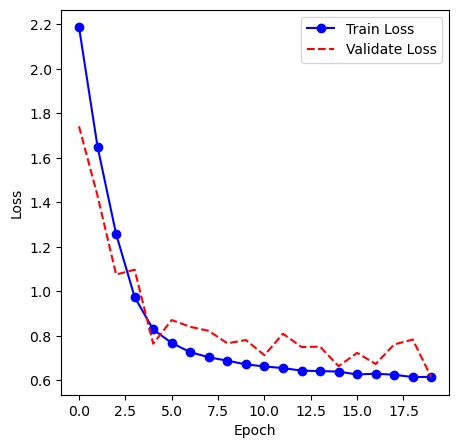

 10%|███████▌                                                                   | 20/200 [2:23:06<21:24:34, 428.19s/it]

Epoch:20
Time:2:29:47.328110
Loss:0.7208819037999589
Total:10000  Correct:7580  CleanAccuracy:0.7580


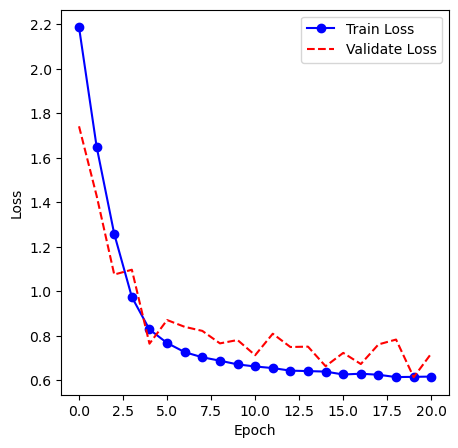

 10%|███████▉                                                                   | 21/200 [2:30:09<21:12:55, 426.68s/it]

Epoch:21
Time:2:36:50.808359
Loss:0.8430285420471106
Total:10000  Correct:7347  CleanAccuracy:0.7347


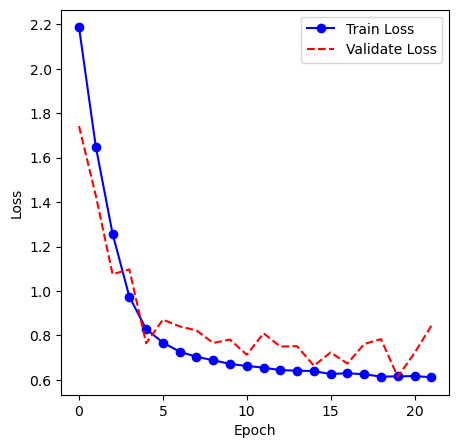

 11%|████████▎                                                                  | 22/200 [2:37:14<21:04:08, 426.12s/it]

Epoch:22
Time:2:44:02.131311
Loss:0.8000370974357898
Total:10000  Correct:7498  CleanAccuracy:0.7498


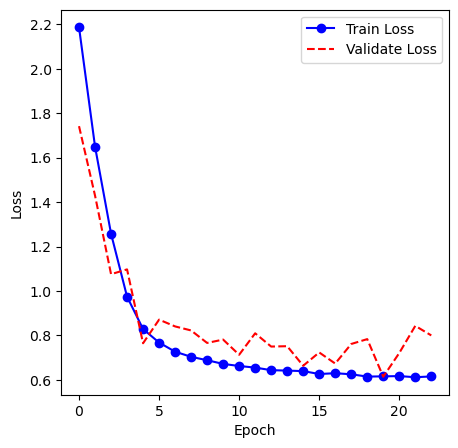

 12%|████████▋                                                                  | 23/200 [2:44:26<21:02:22, 427.92s/it]

Epoch:23
Time:2:51:02.857987
Loss:0.7273180552850516
Total:10000  Correct:7558  CleanAccuracy:0.7558


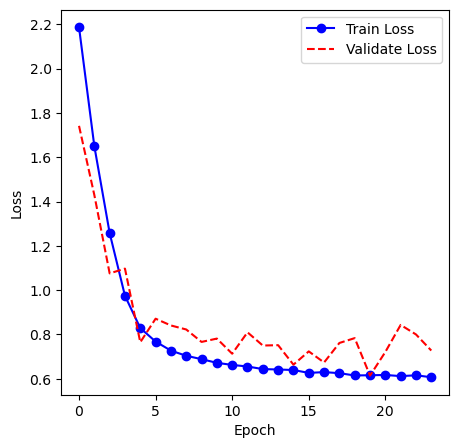

 12%|█████████                                                                  | 24/200 [2:51:27<20:48:59, 425.79s/it]

Epoch:24
Time:2:58:16.953716
Loss:0.69661815340717
Total:10000  Correct:7704  CleanAccuracy:0.7704


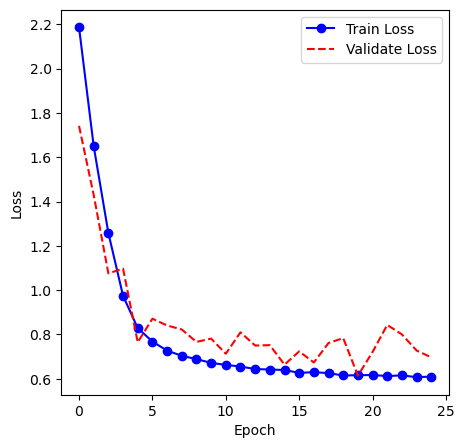

 12%|█████████▍                                                                 | 25/200 [2:58:42<20:49:44, 428.48s/it]

Epoch:25
Time:3:05:29.635591
Loss:0.706929830792613
Total:10000  Correct:7678  CleanAccuracy:0.7678


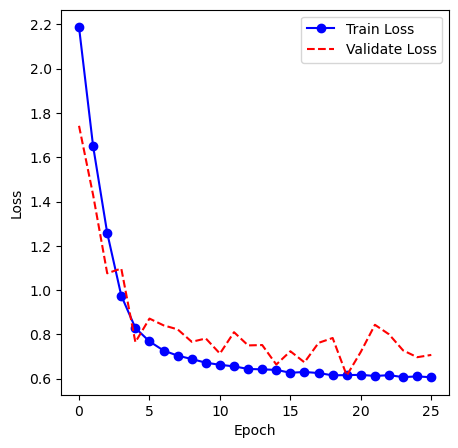

 13%|█████████▊                                                                 | 26/200 [3:05:59<20:50:42, 431.28s/it]

Epoch:26
Time:3:12:49.193139
Loss:1.0375815486184323
Total:10000  Correct:7104  CleanAccuracy:0.7104


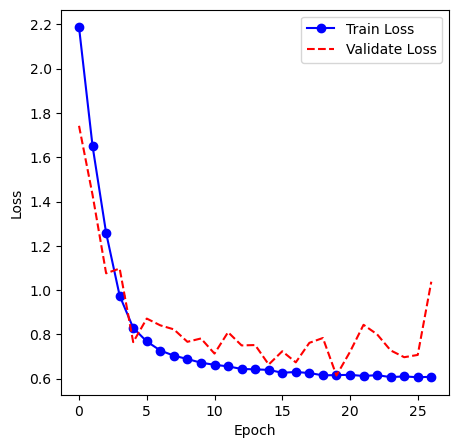

 14%|██████████▏                                                                | 27/200 [3:13:17<20:48:45, 433.10s/it]

Epoch:27
Time:3:20:04.691611
Loss:0.6391409233736154
Total:10000  Correct:7845  CleanAccuracy:0.7845


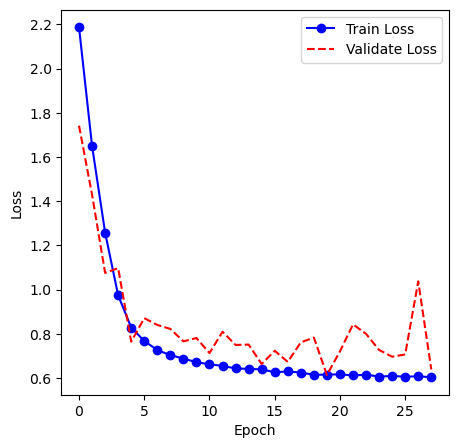

 14%|██████████▌                                                                | 28/200 [3:20:32<20:43:00, 433.61s/it]

Epoch:28
Time:3:27:19.444627
Loss:0.7455698435965438
Total:10000  Correct:7410  CleanAccuracy:0.7410


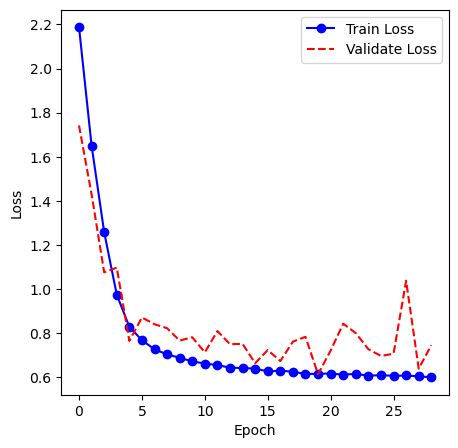

 14%|██████████▉                                                                | 29/200 [3:27:42<20:32:49, 432.57s/it]

Epoch:29
Time:3:34:21.707761
Loss:1.7537938748685697
Total:10000  Correct:5516  CleanAccuracy:0.5516


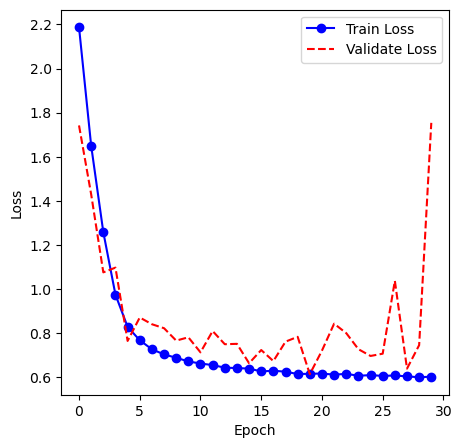

 15%|███████████▎                                                               | 30/200 [3:34:51<20:23:12, 431.72s/it]

Epoch:30
Time:3:41:39.882845
Loss:0.7730793928185972
Total:10000  Correct:7427  CleanAccuracy:0.7427


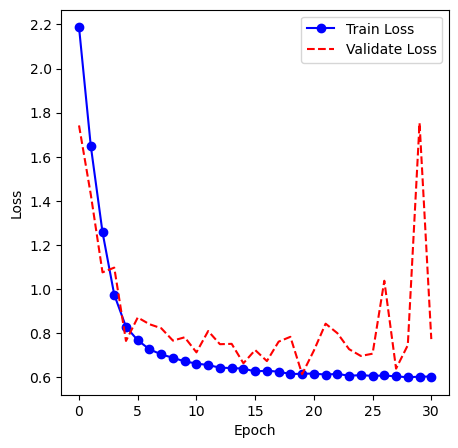

 16%|███████████▋                                                               | 31/200 [3:42:02<20:15:19, 431.48s/it]

Epoch:31
Time:3:48:50.257832
Loss:0.9480532834324212
Total:10000  Correct:7107  CleanAccuracy:0.7107


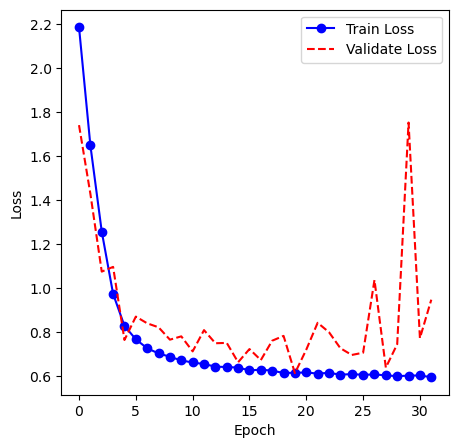

 16%|████████████                                                               | 32/200 [3:49:11<20:05:21, 430.49s/it]

Epoch:32
Time:3:55:54.402023
Loss:0.7655167984315001
Total:10000  Correct:7578  CleanAccuracy:0.7578


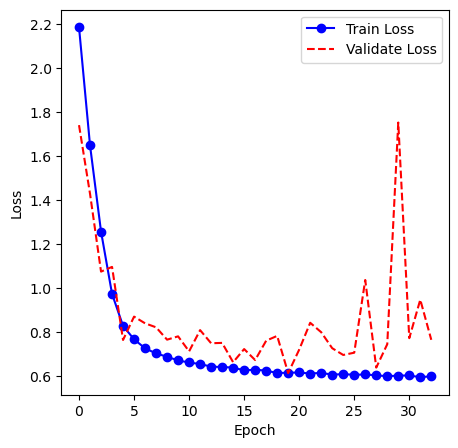

 16%|████████████▍                                                              | 33/200 [3:56:23<19:59:25, 430.93s/it]

Epoch:33
Time:4:03:05.228152
Loss:0.8146007929366237
Total:10000  Correct:7156  CleanAccuracy:0.7156


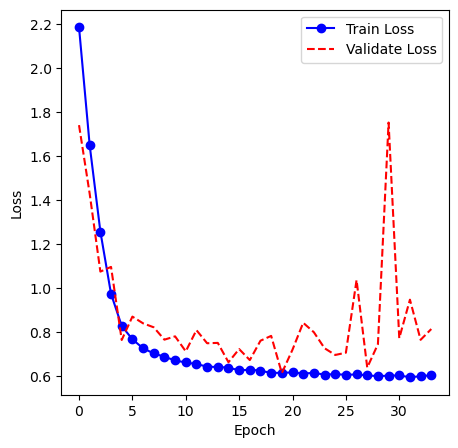

 17%|████████████▊                                                              | 34/200 [4:03:34<19:52:52, 431.16s/it]

Epoch:34
Time:4:10:22.521683
Loss:0.6533121470445261
Total:10000  Correct:7814  CleanAccuracy:0.7814


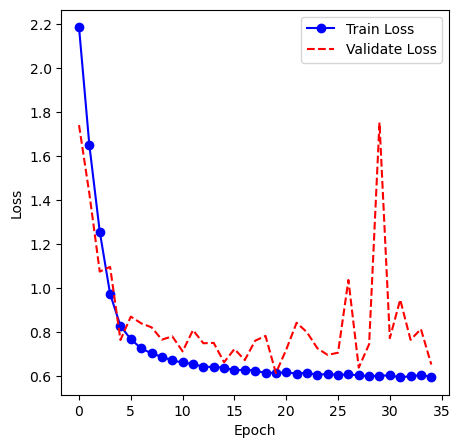

 18%|█████████████▏                                                             | 35/200 [4:10:51<19:50:16, 432.82s/it]

Epoch:35
Time:4:17:33.977053
Loss:0.7076905738240995
Total:10000  Correct:7637  CleanAccuracy:0.7637


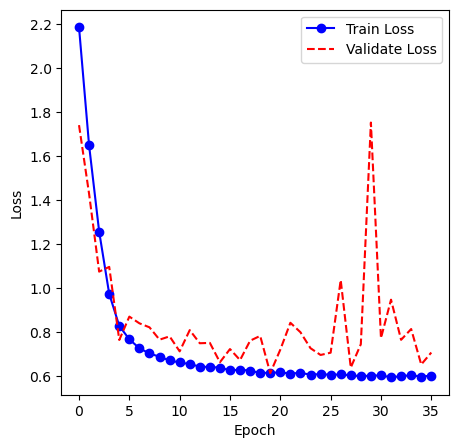

 18%|█████████████▌                                                             | 36/200 [4:17:59<19:39:03, 431.36s/it]

Epoch:36
Time:4:24:44.289522
Loss:0.8944432854461974
Total:10000  Correct:7176  CleanAccuracy:0.7176


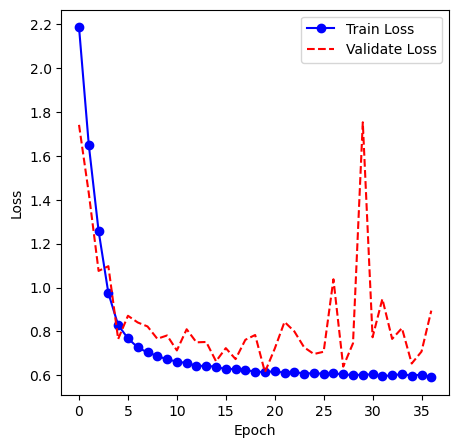

 18%|█████████████▉                                                             | 37/200 [4:25:11<19:32:47, 431.70s/it]

Epoch:37
Time:4:31:55.789757
Loss:0.8754646535308216
Total:10000  Correct:7276  CleanAccuracy:0.7276


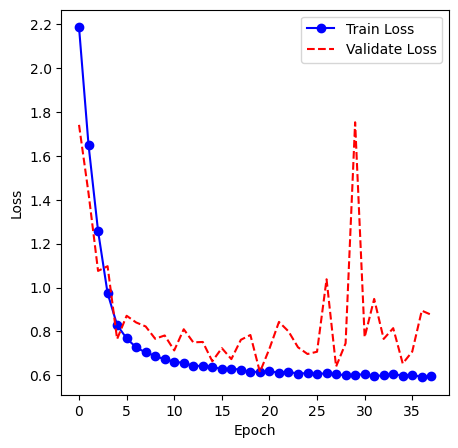

 19%|██████████████▎                                                            | 38/200 [4:32:21<19:24:02, 431.13s/it]

Epoch:38
Time:4:39:02.155447
Loss:0.7423780019671772
Total:10000  Correct:7560  CleanAccuracy:0.7560


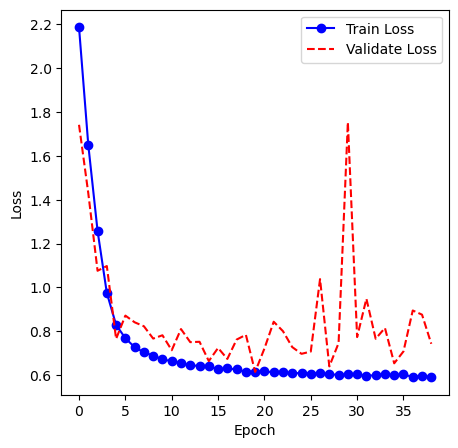

 20%|██████████████▋                                                            | 39/200 [4:39:22<19:08:39, 428.07s/it]

Epoch:39
Time:4:46:08.823179
Loss:0.6767720576768486
Total:10000  Correct:7787  CleanAccuracy:0.7787


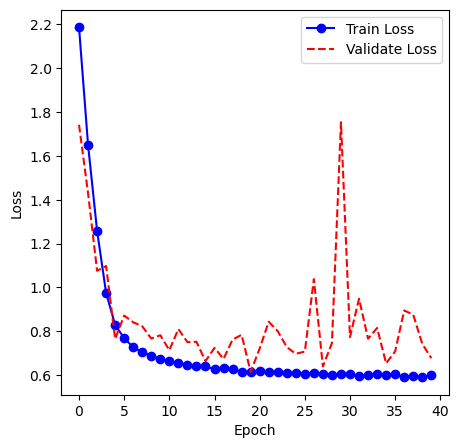

 20%|███████████████                                                            | 40/200 [4:46:28<18:59:23, 427.27s/it]

Epoch:40
Time:4:53:15.421201
Loss:0.7337179227758901
Total:10000  Correct:7618  CleanAccuracy:0.7618


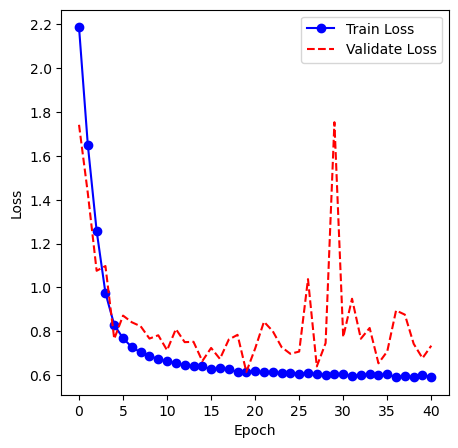

 20%|███████████████▎                                                           | 41/200 [4:53:33<18:51:05, 426.82s/it]

Epoch:41
Time:5:00:16.507905
Loss:0.6742026667815809
Total:10000  Correct:7801  CleanAccuracy:0.7801


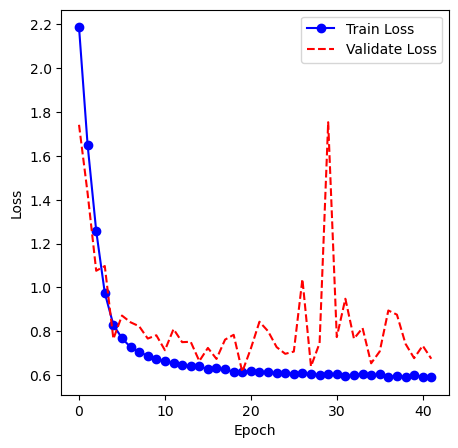

 21%|███████████████▊                                                           | 42/200 [5:00:36<18:40:59, 425.69s/it]

Epoch:42
Time:5:07:19.763787
Loss:0.726106329371754
Total:10000  Correct:7559  CleanAccuracy:0.7559


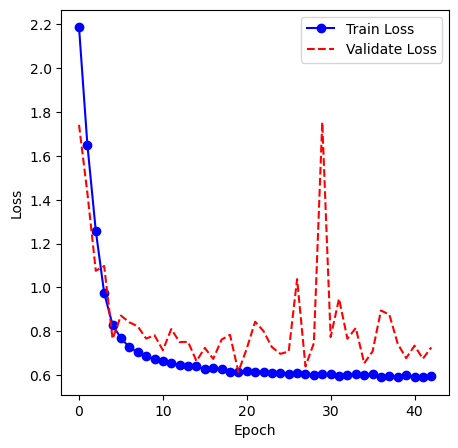

 22%|████████████████▏                                                          | 43/200 [5:07:38<18:30:47, 424.51s/it]

Epoch:43
Time:5:14:18.158502
Loss:0.7067738710500943
Total:10000  Correct:7652  CleanAccuracy:0.7652


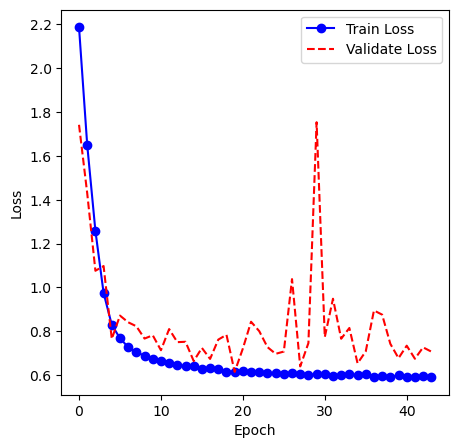

 22%|████████████████▌                                                          | 44/200 [5:14:43<18:23:52, 424.57s/it]

Epoch:44
Time:5:21:27.215391
Loss:0.6433045142374861
Total:10000  Correct:7851  CleanAccuracy:0.7851


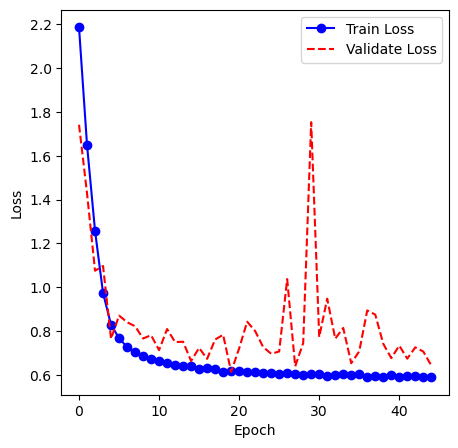

 22%|████████████████▉                                                          | 45/200 [5:21:46<18:15:30, 424.07s/it]

Epoch:45
Time:5:28:34.250250
Loss:0.6360877147688272
Total:10000  Correct:7898  CleanAccuracy:0.7898


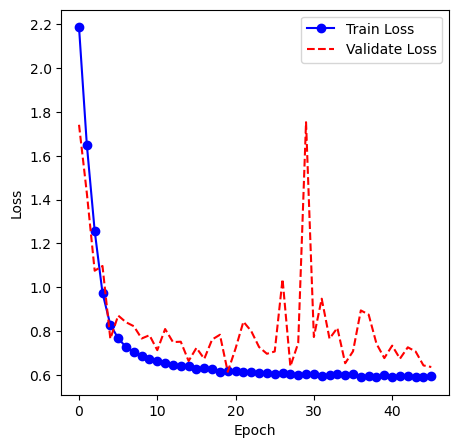

 23%|█████████████████▎                                                         | 46/200 [5:28:58<18:15:06, 426.67s/it]

Epoch:46
Time:5:35:49.469103
Loss:0.7391642355880799
Total:10000  Correct:7499  CleanAccuracy:0.7499


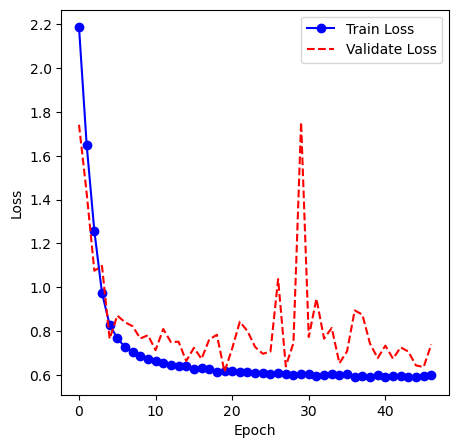

 24%|█████████████████▋                                                         | 47/200 [5:36:17<18:17:15, 430.30s/it]

Epoch:47
Time:5:42:59.470400
Loss:1.1809240536758314
Total:10000  Correct:6657  CleanAccuracy:0.6657


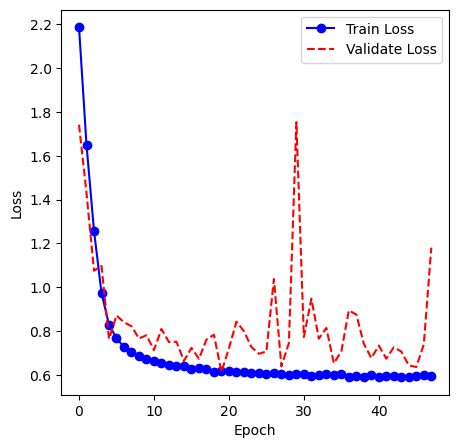

 24%|██████████████████                                                         | 48/200 [5:43:27<18:10:01, 430.28s/it]

Epoch:48
Time:5:50:13.715033
Loss:0.5843083410503004
Total:10000  Correct:8011  CleanAccuracy:0.8011


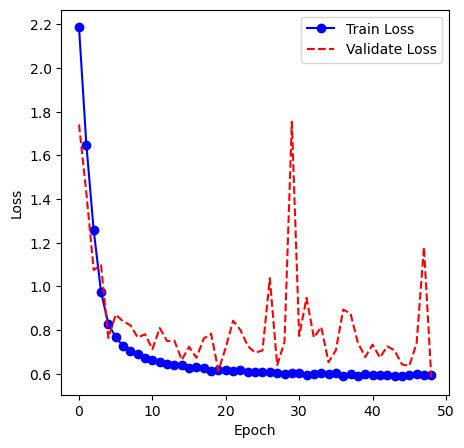

 24%|██████████████████▍                                                        | 49/200 [5:50:38<18:03:23, 430.49s/it]

Epoch:49
Time:5:57:19.209929
Loss:0.7682060333676993
Total:10000  Correct:7461  CleanAccuracy:0.7461


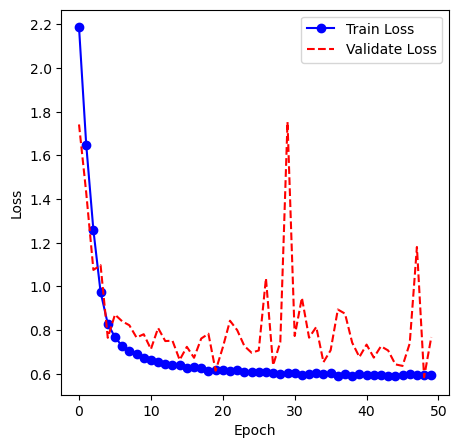

 25%|██████████████████▊                                                        | 50/200 [5:57:39<17:48:45, 427.50s/it]

Epoch:50
Time:6:04:21.718979
Loss:0.7724479876768094
Total:10000  Correct:7429  CleanAccuracy:0.7429


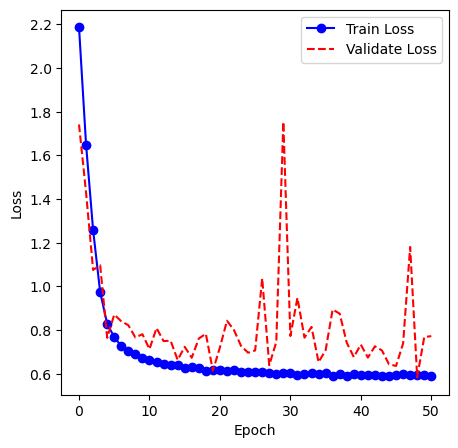

 26%|███████████████████▏                                                       | 51/200 [6:04:51<17:44:51, 428.80s/it]

Epoch:51
Time:6:11:30.729956
Loss:0.7381217660614476
Total:10000  Correct:7579  CleanAccuracy:0.7579


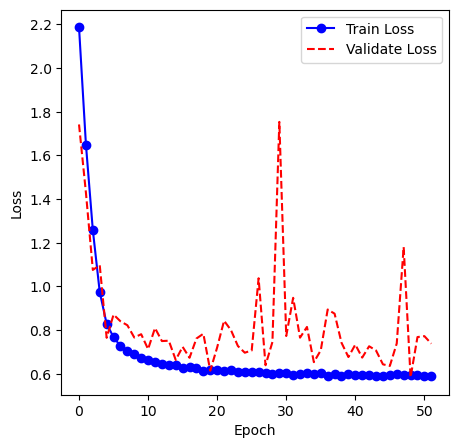

 26%|███████████████████▌                                                       | 52/200 [6:11:53<17:33:04, 426.92s/it]

Epoch:52
Time:6:18:39.581751
Loss:0.7572178638781222
Total:10000  Correct:7560  CleanAccuracy:0.7560


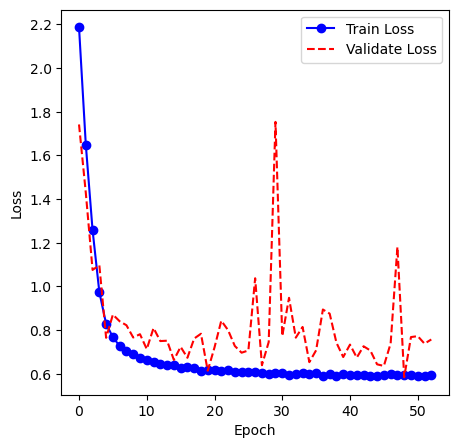

 26%|███████████████████▉                                                       | 53/200 [6:19:04<17:29:01, 428.17s/it]

Epoch:53
Time:6:25:56.148542
Loss:1.0797964268789504
Total:10000  Correct:6786  CleanAccuracy:0.6786


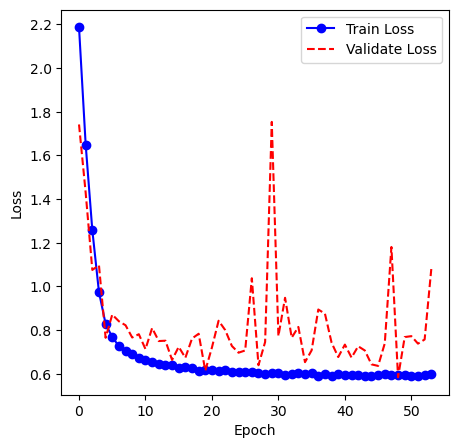

 27%|████████████████████▎                                                      | 54/200 [6:26:20<17:27:38, 430.54s/it]

Epoch:54
Time:6:33:08.067840
Loss:0.7117520283205441
Total:10000  Correct:7457  CleanAccuracy:0.7457


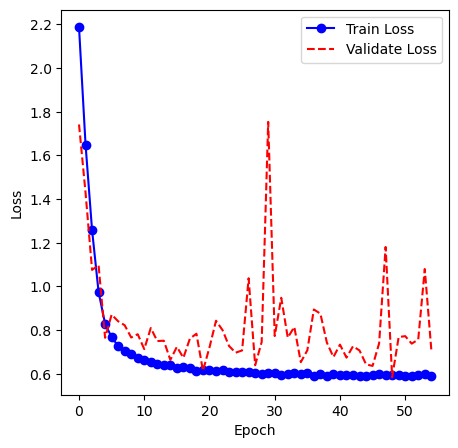

 28%|████████████████████▋                                                      | 55/200 [6:33:28<17:18:10, 429.59s/it]

Epoch:55
Time:6:40:17.629696
Loss:1.0618094796189865
Total:10000  Correct:6854  CleanAccuracy:0.6854


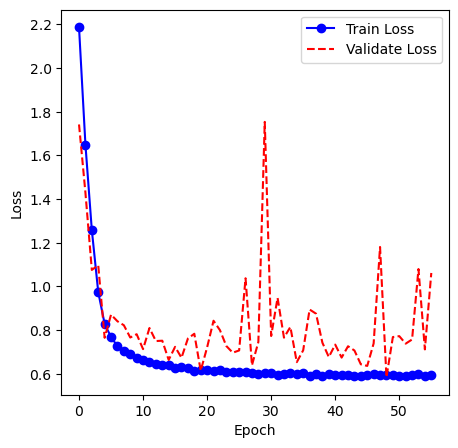

 28%|█████████████████████                                                      | 56/200 [6:40:48<17:18:17, 432.62s/it]

Epoch:56
Time:6:47:33.388919
Loss:0.7692695277186629
Total:10000  Correct:7477  CleanAccuracy:0.7477


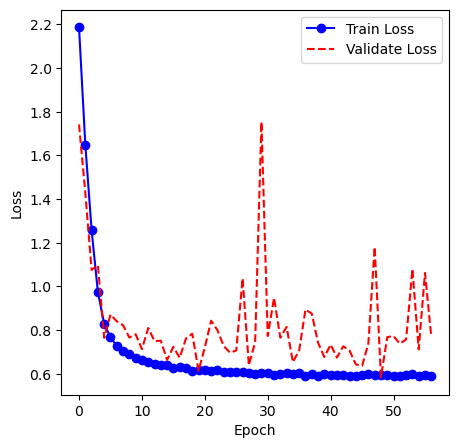

 28%|█████████████████████▎                                                     | 57/200 [6:47:55<17:07:07, 430.96s/it]

Epoch:57
Time:6:54:37.608929
Loss:0.7624024775462409
Total:10000  Correct:7591  CleanAccuracy:0.7591


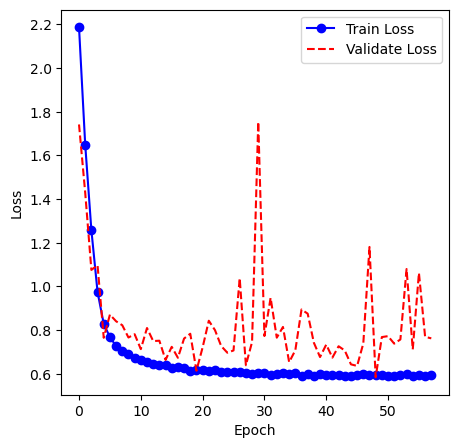

 29%|█████████████████████▊                                                     | 58/200 [6:54:56<16:53:26, 428.22s/it]

Epoch:58
Time:7:01:41.800026
Loss:0.7720538140676273
Total:10000  Correct:7520  CleanAccuracy:0.7520


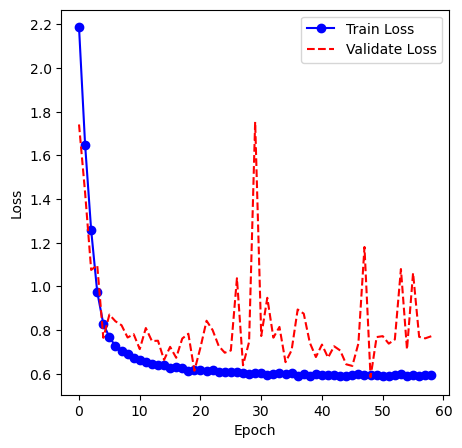

 30%|██████████████████████▏                                                    | 59/200 [7:01:59<16:42:32, 426.61s/it]

Epoch:59
Time:7:08:46.876335
Loss:0.6363831759927372
Total:10000  Correct:7929  CleanAccuracy:0.7929


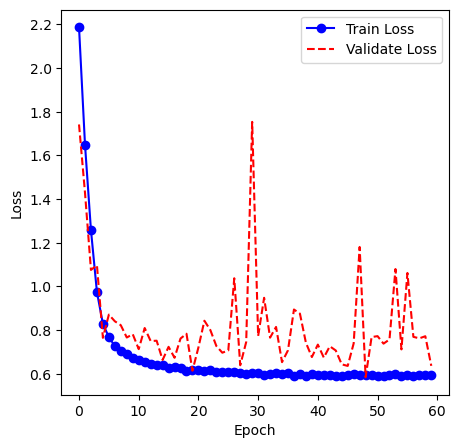

 30%|██████████████████████▌                                                    | 60/200 [7:09:05<16:35:05, 426.47s/it]

Epoch:60
Time:7:16:01.532867
Loss:0.2871708840774462
Total:10000  Correct:9001  CleanAccuracy:0.9001


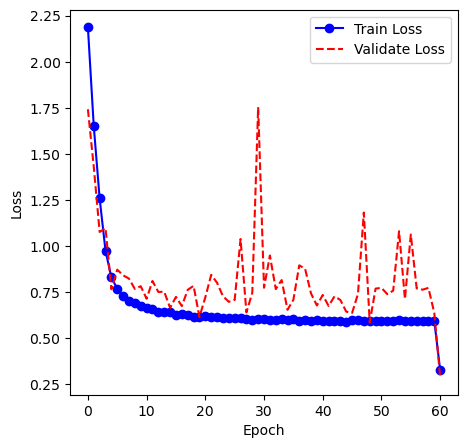

 30%|██████████████████████▉                                                    | 61/200 [7:16:24<16:36:12, 430.02s/it]

Epoch:61
Time:7:23:11.299881
Loss:0.2752059484346987
Total:10000  Correct:9052  CleanAccuracy:0.9052


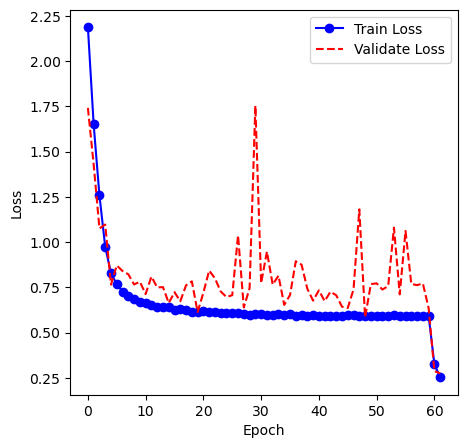

 31%|███████████████████████▎                                                   | 62/200 [7:23:32<16:27:37, 429.40s/it]

Epoch:62
Time:7:30:13.649475
Loss:0.2504379557677732
Total:10000  Correct:9129  CleanAccuracy:0.9129


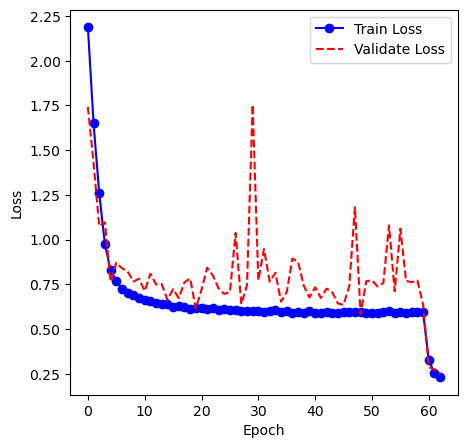

 32%|███████████████████████▋                                                   | 63/200 [7:30:43<16:21:36, 429.90s/it]

Epoch:63
Time:7:37:31.553497
Loss:0.253135561127775
Total:10000  Correct:9117  CleanAccuracy:0.9117


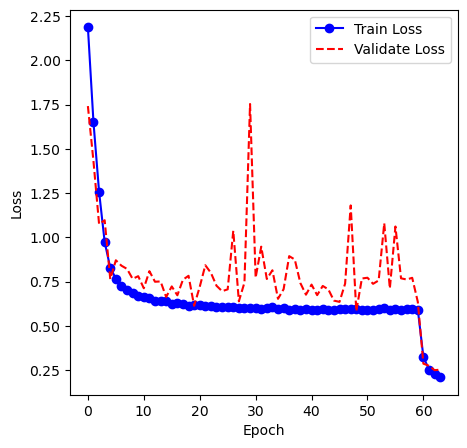

 32%|████████████████████████                                                   | 64/200 [7:37:55<16:16:06, 430.63s/it]

Epoch:64
Time:7:44:47.963875
Loss:0.24314566237477067
Total:10000  Correct:9158  CleanAccuracy:0.9158


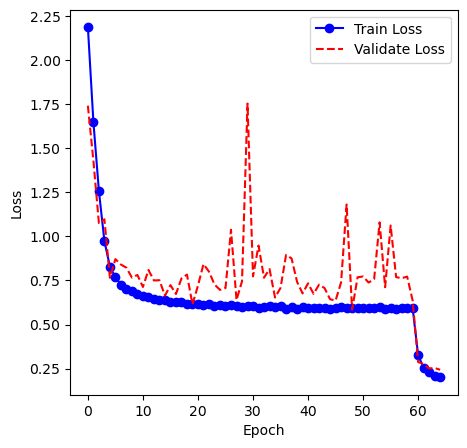

 32%|████████████████████████▍                                                  | 65/200 [7:45:11<16:12:44, 432.33s/it]

Epoch:65
Time:7:51:59.734298
Loss:0.2642250121556246
Total:10000  Correct:9131  CleanAccuracy:0.9131


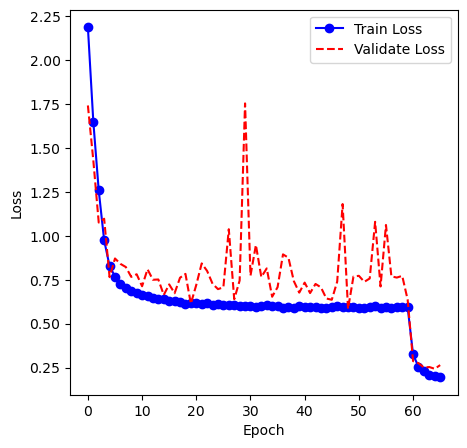

 33%|████████████████████████▊                                                  | 66/200 [7:52:23<16:05:21, 432.25s/it]

Epoch:66
Time:7:59:21.641675
Loss:0.2671840329038592
Total:10000  Correct:9062  CleanAccuracy:0.9062


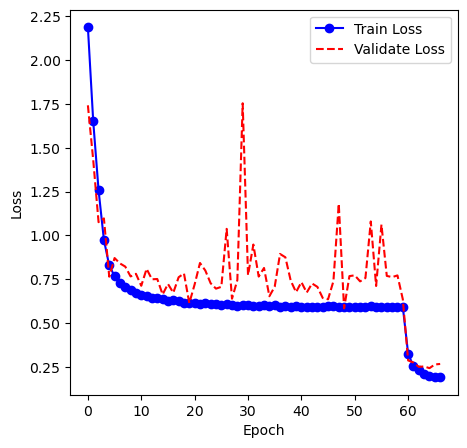

 34%|█████████████████████████▏                                                 | 67/200 [7:59:52<16:08:44, 437.03s/it]

Epoch:67
Time:8:06:41.813727
Loss:0.26399184672977216
Total:10000  Correct:9093  CleanAccuracy:0.9093


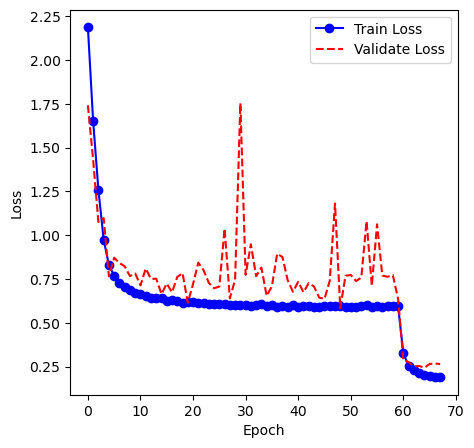

 34%|█████████████████████████▌                                                 | 68/200 [8:07:09<16:01:35, 437.09s/it]

Epoch:68
Time:8:13:58.559337
Loss:0.27128490014745593
Total:10000  Correct:9116  CleanAccuracy:0.9116


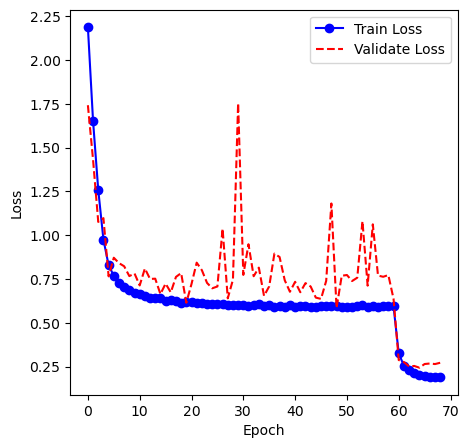

 34%|█████████████████████████▊                                                 | 69/200 [8:14:28<15:55:33, 437.66s/it]

Epoch:69
Time:8:21:19.574663
Loss:0.2789402677418706
Total:10000  Correct:9071  CleanAccuracy:0.9071


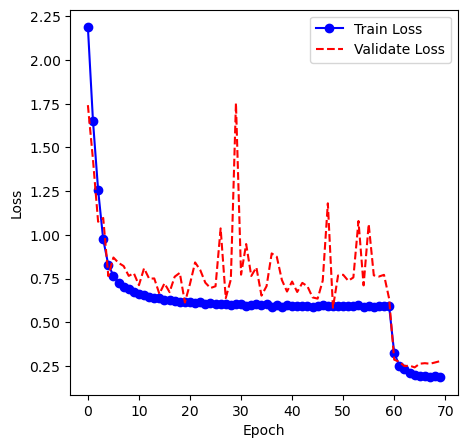

 35%|██████████████████████████▎                                                | 70/200 [8:21:45<15:48:03, 437.57s/it]

Epoch:70
Time:8:28:32.803081
Loss:0.26370041258633137
Total:10000  Correct:9120  CleanAccuracy:0.9120


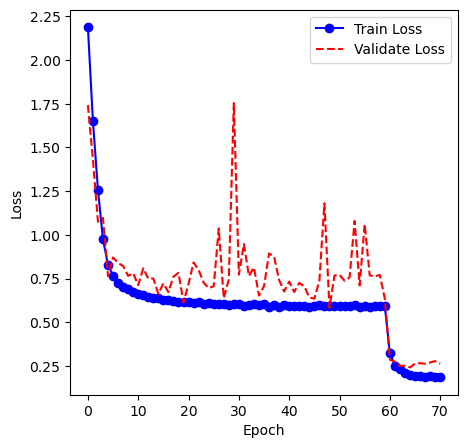

 36%|██████████████████████████▋                                                | 71/200 [8:29:03<15:40:48, 437.59s/it]

Epoch:71
Time:8:35:50.402258
Loss:0.29872326993832765
Total:10000  Correct:9007  CleanAccuracy:0.9007


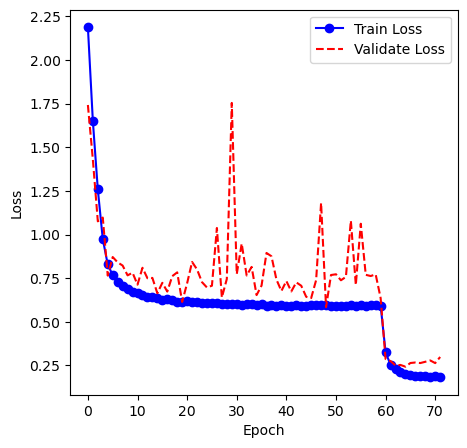

 36%|███████████████████████████                                                | 72/200 [8:36:20<15:33:18, 437.49s/it]

Epoch:72
Time:8:43:08.246011
Loss:0.2629396057607362
Total:10000  Correct:9131  CleanAccuracy:0.9131


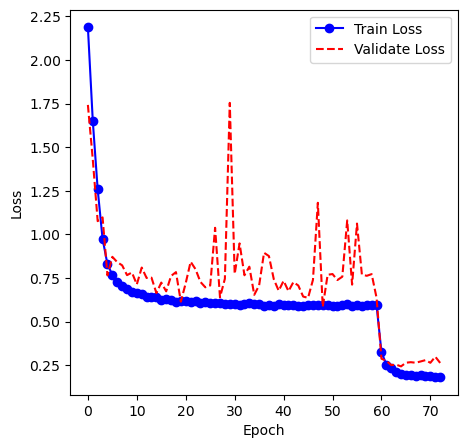

 36%|███████████████████████████▍                                               | 73/200 [8:43:37<15:25:36, 437.30s/it]

Epoch:73
Time:8:50:24.687356
Loss:0.2619733571881256
Total:10000  Correct:9155  CleanAccuracy:0.9155


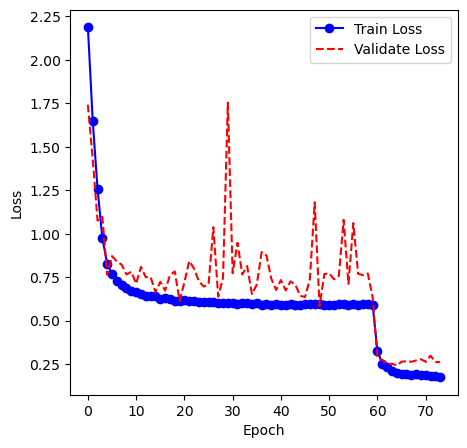

 37%|███████████████████████████▊                                               | 74/200 [8:50:53<15:17:30, 436.91s/it]

Epoch:74
Time:8:57:43.828880
Loss:0.2967299842647613
Total:10000  Correct:9013  CleanAccuracy:0.9013


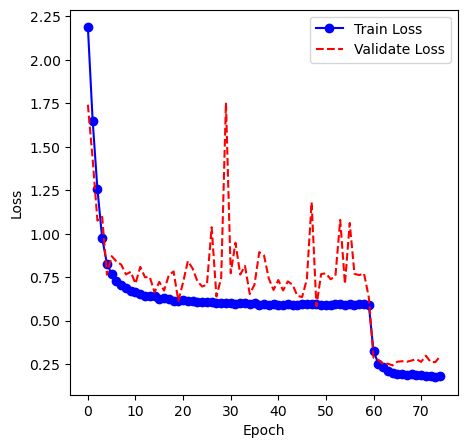

 38%|████████████████████████████▏                                              | 75/200 [8:58:05<15:06:57, 435.34s/it]

Epoch:75
Time:9:04:50.005117
Loss:0.3151984240014713
Total:10000  Correct:8982  CleanAccuracy:0.8982


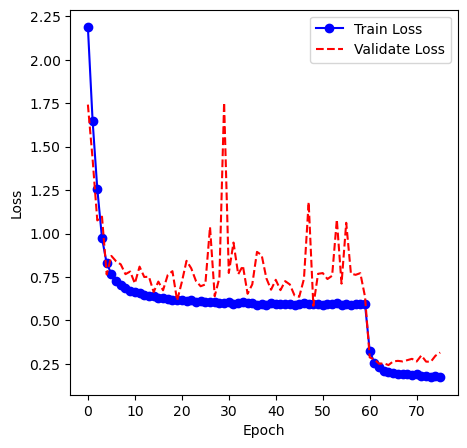

 38%|████████████████████████████▌                                              | 76/200 [9:05:10<14:53:28, 432.32s/it]

Epoch:76
Time:9:11:54.584465
Loss:0.2737277801693105
Total:10000  Correct:9074  CleanAccuracy:0.9074


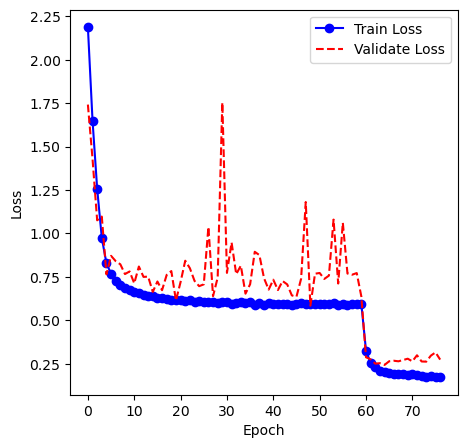

 38%|████████████████████████████▉                                              | 77/200 [9:12:18<14:43:36, 431.03s/it]

Epoch:77
Time:9:19:10.693147
Loss:0.2988784086411468
Total:10000  Correct:9006  CleanAccuracy:0.9006


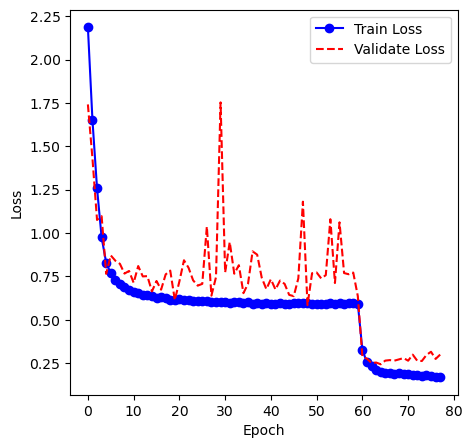

 39%|█████████████████████████████▎                                             | 78/200 [9:19:29<14:36:36, 431.12s/it]

Epoch:78
Time:9:26:17.549668
Loss:0.26094442850556043
Total:10000  Correct:9136  CleanAccuracy:0.9136


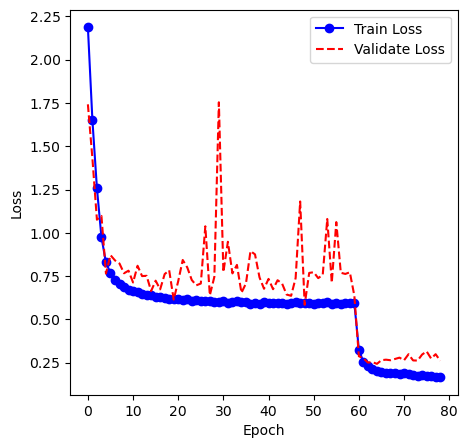

 40%|█████████████████████████████▋                                             | 79/200 [9:26:43<14:30:53, 431.85s/it]

Epoch:79
Time:9:33:31.727621
Loss:0.27356687776399213
Total:10000  Correct:9134  CleanAccuracy:0.9134


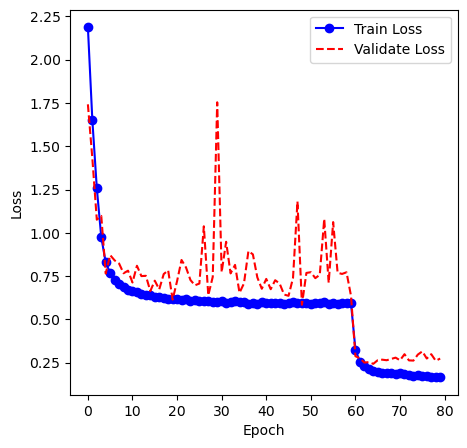

 40%|██████████████████████████████                                             | 80/200 [9:33:52<14:22:01, 431.02s/it]

Epoch:80
Time:9:40:39.912629
Loss:0.3232728269058295
Total:10000  Correct:8940  CleanAccuracy:0.8940


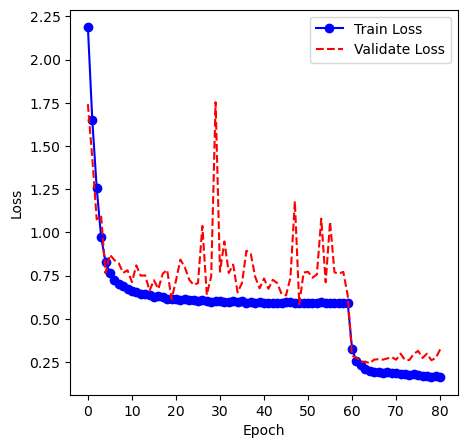

 40%|██████████████████████████████▍                                            | 81/200 [9:41:02<14:14:16, 430.73s/it]

Epoch:81
Time:9:47:48.394879
Loss:0.29961970209861144
Total:10000  Correct:9039  CleanAccuracy:0.9039


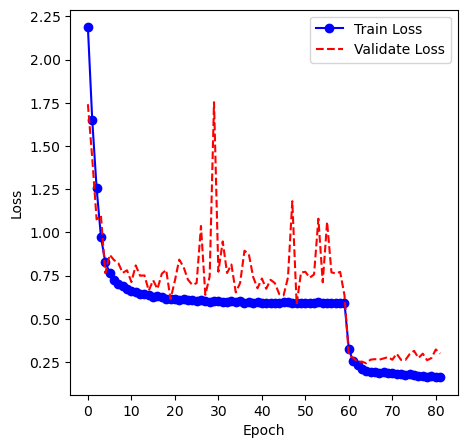

 41%|██████████████████████████████▋                                            | 82/200 [9:48:11<14:06:01, 430.18s/it]

Epoch:82
Time:9:54:59.177606
Loss:0.27497536389710614
Total:10000  Correct:9094  CleanAccuracy:0.9094


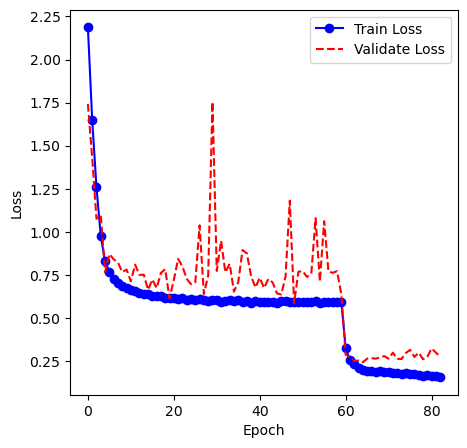

 42%|███████████████████████████████▏                                           | 83/200 [9:55:19<13:57:42, 429.60s/it]

Epoch:83
Time:10:02:12.995916
Loss:0.3193368660494352
Total:10000  Correct:8975  CleanAccuracy:0.8975


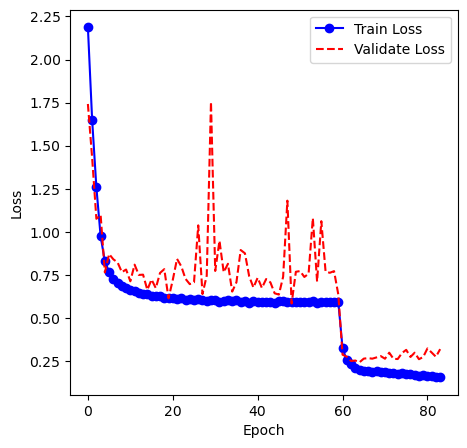

 42%|███████████████████████████████                                           | 84/200 [10:02:40<13:57:25, 433.15s/it]

Epoch:84
Time:10:09:31.929524
Loss:0.28508048775953987
Total:10000  Correct:9065  CleanAccuracy:0.9065


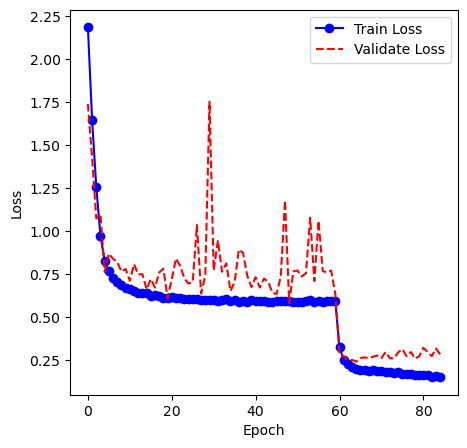

 42%|███████████████████████████████▍                                          | 85/200 [10:09:52<13:49:11, 432.62s/it]

Epoch:85
Time:10:16:41.721512
Loss:0.2891235595848709
Total:10000  Correct:9059  CleanAccuracy:0.9059


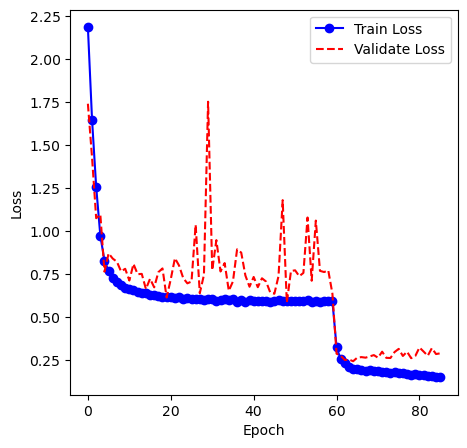

 43%|███████████████████████████████▊                                          | 86/200 [10:17:04<13:41:28, 432.36s/it]

Epoch:86
Time:10:23:53.398398
Loss:0.28785214001854387
Total:10000  Correct:9036  CleanAccuracy:0.9036


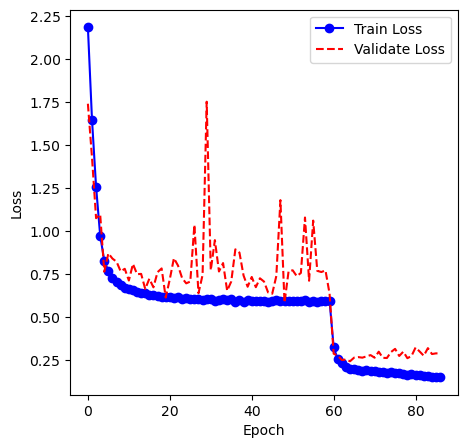

 44%|████████████████████████████████▏                                         | 87/200 [10:24:14<13:32:56, 431.65s/it]

Epoch:87
Time:10:31:02.939009
Loss:0.2463260538632068
Total:10000  Correct:9172  CleanAccuracy:0.9172


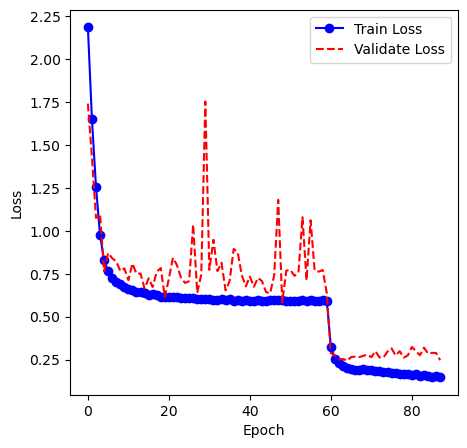

 44%|████████████████████████████████▌                                         | 88/200 [10:31:23<13:24:32, 431.00s/it]

Epoch:88
Time:10:38:12.292144
Loss:0.3071130182379827
Total:10000  Correct:9015  CleanAccuracy:0.9015


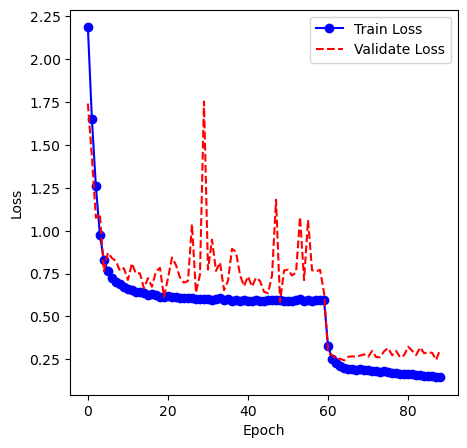

 44%|████████████████████████████████▉                                         | 89/200 [10:38:37<13:19:12, 432.01s/it]

Epoch:89
Time:10:45:27.281374
Loss:0.2836665864037082
Total:10000  Correct:9071  CleanAccuracy:0.9071


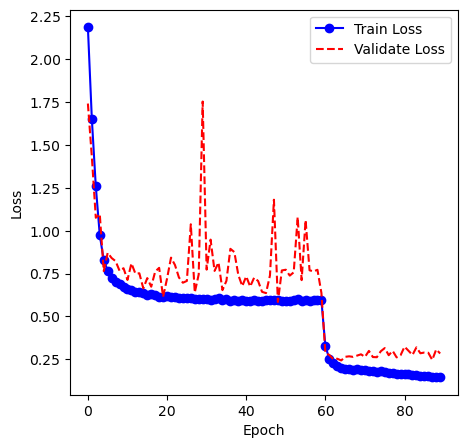

 45%|█████████████████████████████████▎                                        | 90/200 [10:45:52<13:13:30, 432.82s/it]

Epoch:90
Time:10:52:41.289900
Loss:0.2749381744014189
Total:10000  Correct:9133  CleanAccuracy:0.9133


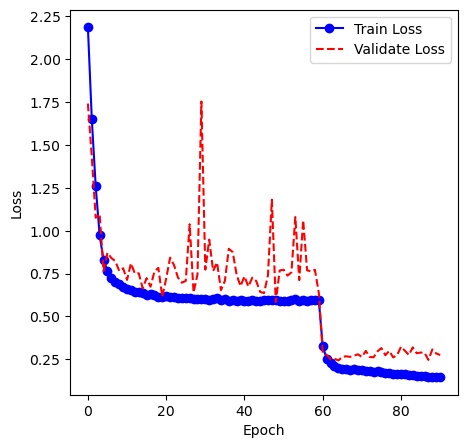

 46%|█████████████████████████████████▋                                        | 91/200 [10:53:02<13:04:48, 432.00s/it]

Epoch:91
Time:10:59:54.764350
Loss:0.29468004760174704
Total:10000  Correct:9058  CleanAccuracy:0.9058


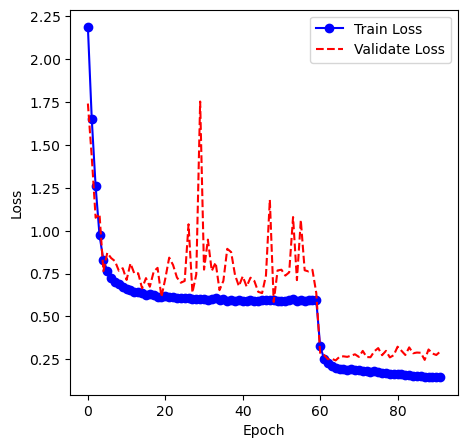

 46%|██████████████████████████████████                                        | 92/200 [11:00:18<12:59:41, 433.17s/it]

Epoch:92
Time:11:07:06.842621
Loss:0.28265623923855276
Total:10000  Correct:9093  CleanAccuracy:0.9093


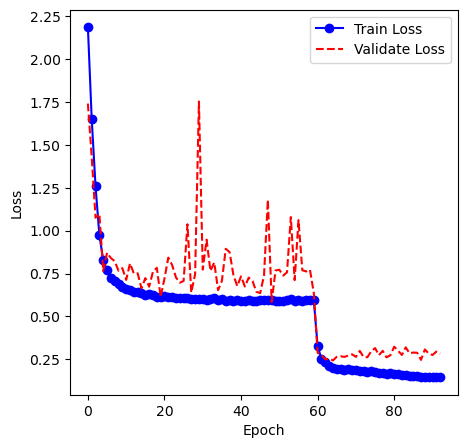

 46%|██████████████████████████████████▍                                       | 93/200 [11:07:31<12:52:16, 433.05s/it]

Epoch:93
Time:11:14:20.061673
Loss:0.2549002998100873
Total:10000  Correct:9163  CleanAccuracy:0.9163


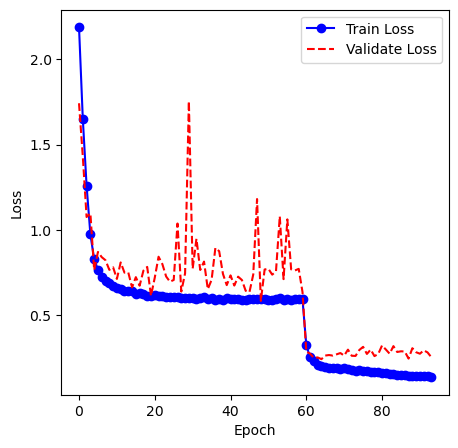

 47%|██████████████████████████████████▊                                       | 94/200 [11:14:42<12:43:53, 432.40s/it]

Epoch:94
Time:11:21:33.971625
Loss:0.2770377481266999
Total:10000  Correct:9089  CleanAccuracy:0.9089


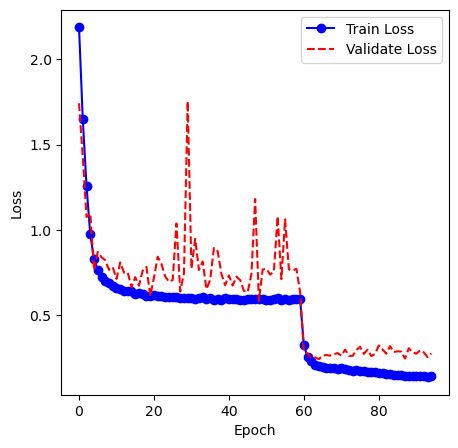

 48%|███████████████████████████████████▏                                      | 95/200 [11:22:02<12:41:00, 434.87s/it]

Epoch:95
Time:11:28:46.207891
Loss:0.30796144464270425
Total:10000  Correct:9045  CleanAccuracy:0.9045


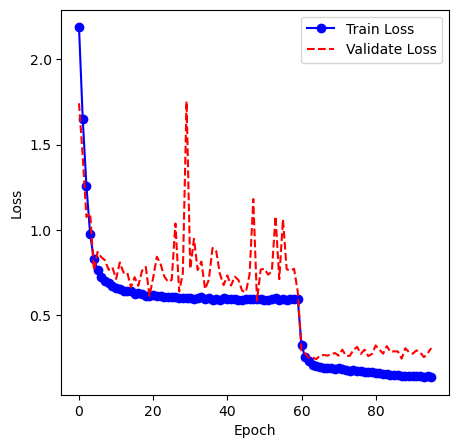

 48%|███████████████████████████████████▌                                      | 96/200 [11:29:08<12:28:54, 432.06s/it]

Epoch:96
Time:11:35:56.061465
Loss:0.2604318045990202
Total:10000  Correct:9151  CleanAccuracy:0.9151


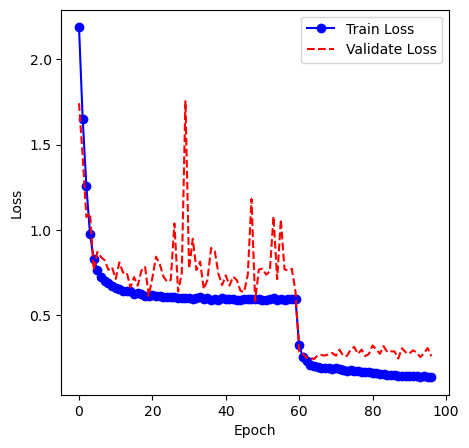

 48%|███████████████████████████████████▉                                      | 97/200 [11:36:15<12:19:16, 430.64s/it]

Epoch:97
Time:11:43:04.161768
Loss:0.24551942405371238
Total:10000  Correct:9213  CleanAccuracy:0.9213


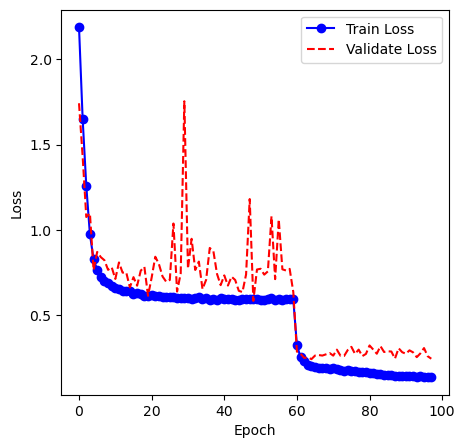

 49%|████████████████████████████████████▎                                     | 98/200 [11:43:24<12:11:17, 430.17s/it]

Epoch:98
Time:11:50:16.272864
Loss:0.2814745435003227
Total:10000  Correct:9130  CleanAccuracy:0.9130


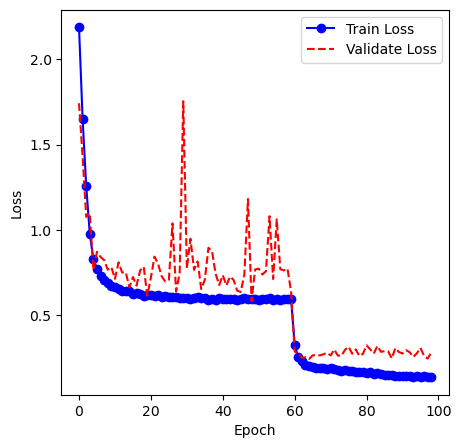

 50%|████████████████████████████████████▋                                     | 99/200 [11:50:38<12:05:41, 431.11s/it]

Epoch:99
Time:11:57:26.564394
Loss:0.26543026208020626
Total:10000  Correct:9150  CleanAccuracy:0.9150


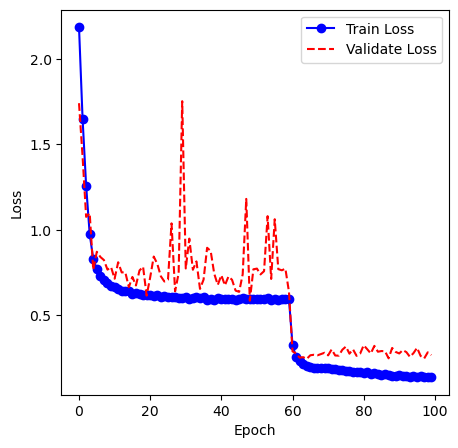

 50%|████████████████████████████████████▌                                    | 100/200 [11:57:53<12:00:27, 432.27s/it]

Epoch:100
Time:12:04:44.999583
Loss:0.29090547329261185
Total:10000  Correct:9099  CleanAccuracy:0.9099


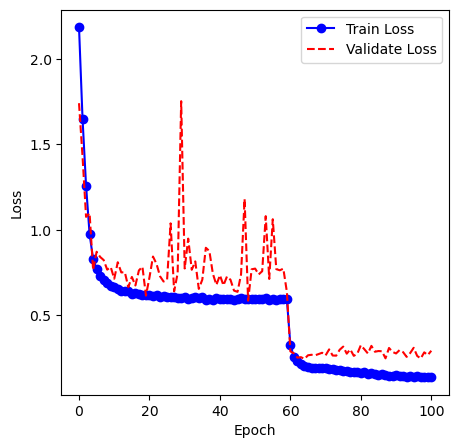

 50%|████████████████████████████████████▊                                    | 101/200 [12:05:04<11:52:38, 431.91s/it]

Epoch:101
Time:12:11:52.524346
Loss:0.28054909308116655
Total:10000  Correct:9090  CleanAccuracy:0.9090


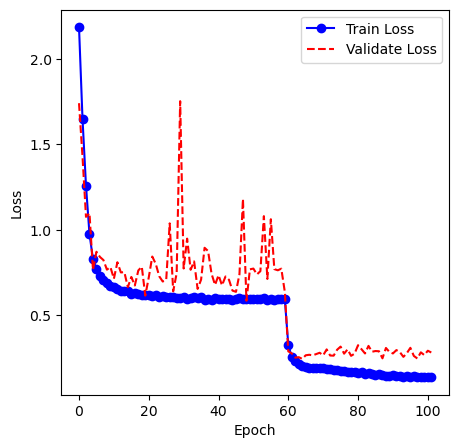

 51%|█████████████████████████████████████▏                                   | 102/200 [12:12:22<11:48:43, 433.91s/it]

Epoch:102
Time:12:19:15.220364
Loss:0.2963845831499741
Total:10000  Correct:9093  CleanAccuracy:0.9093


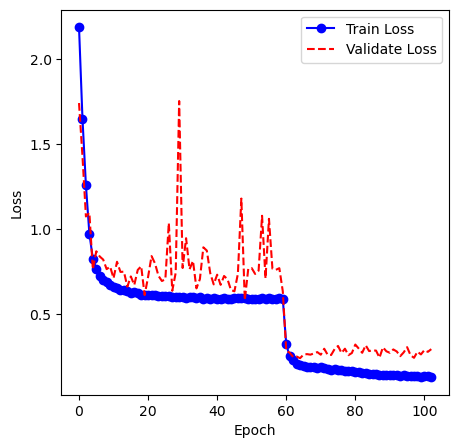

 52%|█████████████████████████████████████▌                                   | 103/200 [12:19:39<11:43:01, 434.86s/it]

Epoch:103
Time:12:26:33.753513
Loss:0.25987796187876894
Total:10000  Correct:9163  CleanAccuracy:0.9163


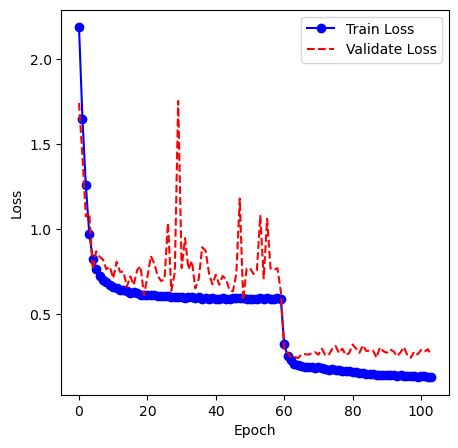

 52%|█████████████████████████████████████▉                                   | 104/200 [12:26:57<11:36:53, 435.56s/it]

Epoch:104
Time:12:33:42.963411
Loss:0.2454351024782529
Total:10000  Correct:9189  CleanAccuracy:0.9189


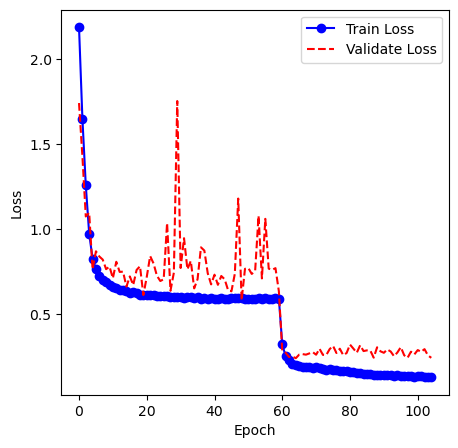

 52%|██████████████████████████████████████▎                                  | 105/200 [12:34:08<11:27:40, 434.32s/it]

Epoch:105
Time:12:40:59.976290
Loss:0.28505017640539254
Total:10000  Correct:9072  CleanAccuracy:0.9072


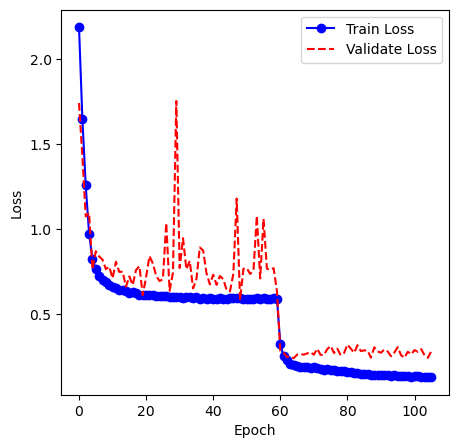

 53%|██████████████████████████████████████▋                                  | 106/200 [12:41:28<11:23:05, 436.02s/it]

Epoch:106
Time:12:48:18.203713
Loss:0.291954642679459
Total:10000  Correct:9059  CleanAccuracy:0.9059


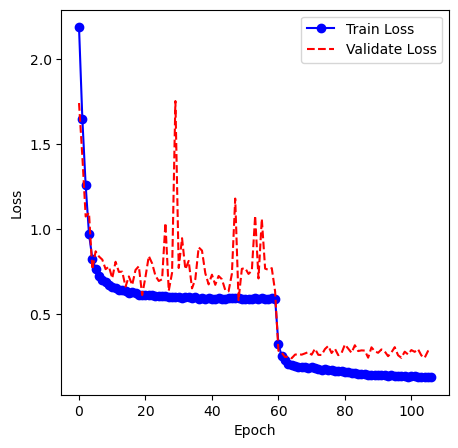

 54%|███████████████████████████████████████                                  | 107/200 [12:48:46<11:16:34, 436.50s/it]

Epoch:107
Time:12:55:35.916531
Loss:0.25022706894662244
Total:10000  Correct:9179  CleanAccuracy:0.9179


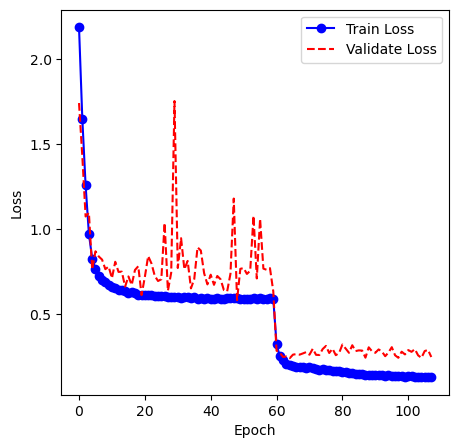

 54%|███████████████████████████████████████▍                                 | 108/200 [12:56:02<11:09:13, 436.45s/it]

Epoch:108
Time:13:02:45.651799
Loss:0.26271334436302557
Total:10000  Correct:9156  CleanAccuracy:0.9156


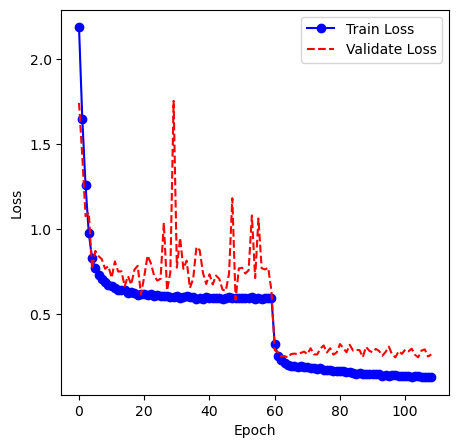

 55%|███████████████████████████████████████▊                                 | 109/200 [13:03:12<10:58:59, 434.50s/it]

Epoch:109
Time:13:10:02.465480
Loss:0.2652348570537548
Total:10000  Correct:9150  CleanAccuracy:0.9150


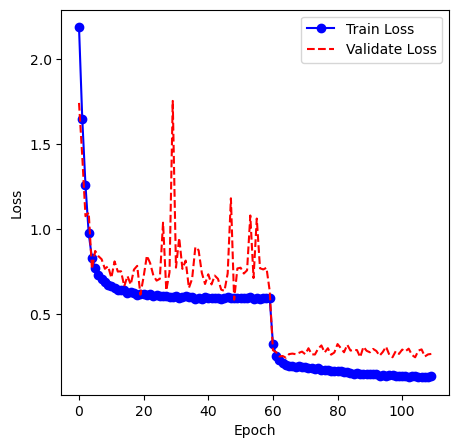

 55%|████████████████████████████████████████▏                                | 110/200 [13:10:21<10:49:26, 432.97s/it]

Epoch:110
Time:13:17:13.558868
Loss:0.28795650332999495
Total:10000  Correct:9105  CleanAccuracy:0.9105


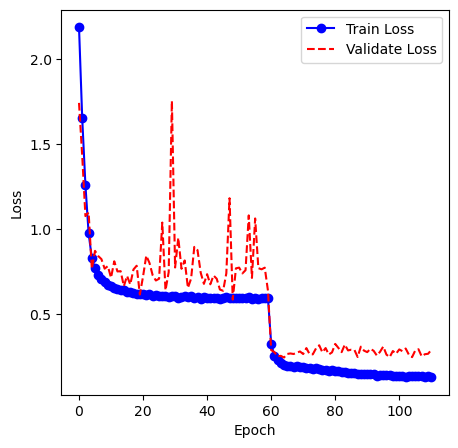

 56%|████████████████████████████████████████▌                                | 111/200 [13:17:31<10:41:00, 432.15s/it]

Epoch:111
Time:13:24:18.001085
Loss:0.34757786107579836
Total:10000  Correct:8927  CleanAccuracy:0.8927


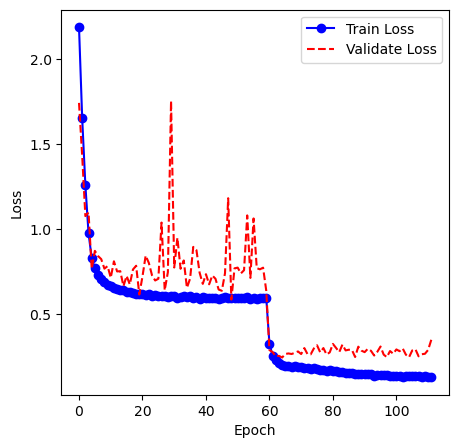

 56%|████████████████████████████████████████▉                                | 112/200 [13:24:40<10:32:21, 431.16s/it]

Epoch:112
Time:13:31:27.863709
Loss:0.2804231447682451
Total:10000  Correct:9129  CleanAccuracy:0.9129


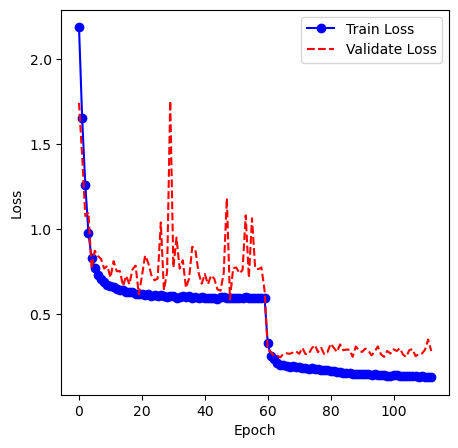

 56%|█████████████████████████████████████████▏                               | 113/200 [13:31:51<10:24:48, 430.90s/it]

Epoch:113
Time:13:38:40.124828
Loss:0.2691221262369983
Total:10000  Correct:9142  CleanAccuracy:0.9142


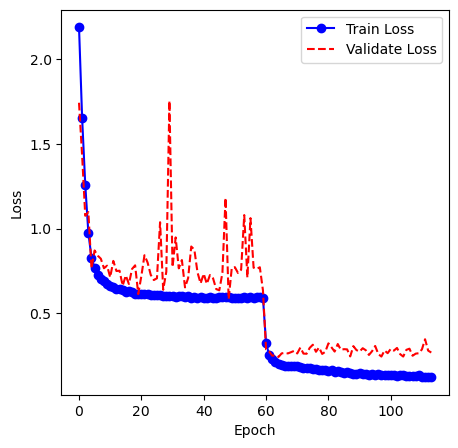

 57%|█████████████████████████████████████████▌                               | 114/200 [13:39:00<10:16:54, 430.40s/it]

Epoch:114
Time:13:45:48.175024
Loss:0.28947006174015066
Total:10000  Correct:9125  CleanAccuracy:0.9125


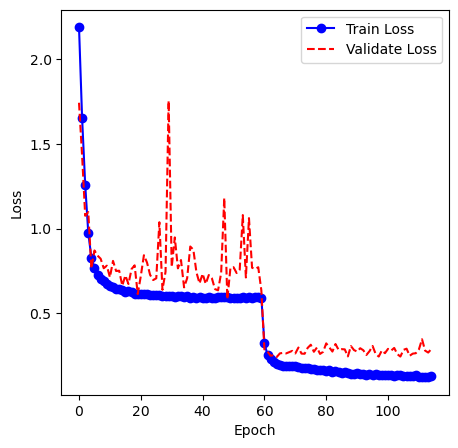

 57%|█████████████████████████████████████████▉                               | 115/200 [13:46:06<10:08:07, 429.27s/it]

Epoch:115
Time:13:52:54.157164
Loss:0.2719057240573981
Total:10000  Correct:9135  CleanAccuracy:0.9135


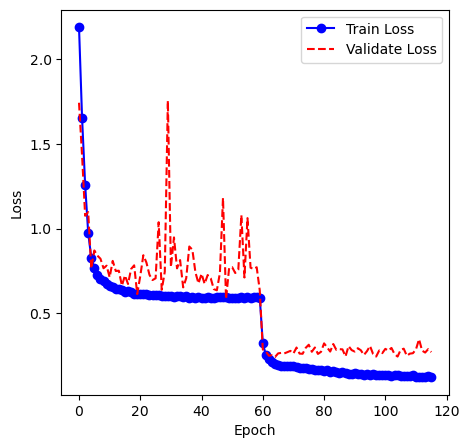

 58%|██████████████████████████████████████████▉                               | 116/200 [13:53:13<9:59:52, 428.49s/it]

Epoch:116
Time:14:00:02.283000
Loss:0.27556778583675623
Total:10000  Correct:9133  CleanAccuracy:0.9133


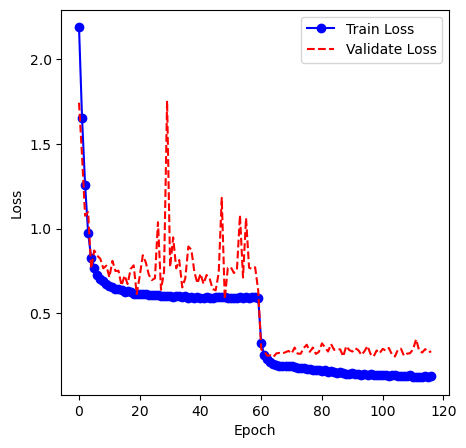

 58%|███████████████████████████████████████████▎                              | 117/200 [14:00:21<9:52:31, 428.33s/it]

Epoch:117
Time:14:07:09.660013
Loss:0.26451004413811985
Total:10000  Correct:9177  CleanAccuracy:0.9177


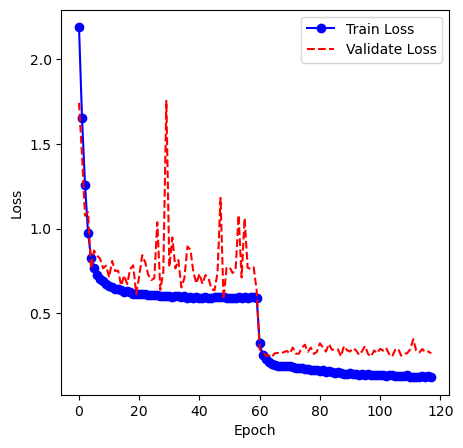

 59%|███████████████████████████████████████████▋                              | 118/200 [14:07:28<9:44:57, 428.02s/it]

Epoch:118
Time:14:14:18.434528
Loss:0.24690888549376744
Total:10000  Correct:9217  CleanAccuracy:0.9217


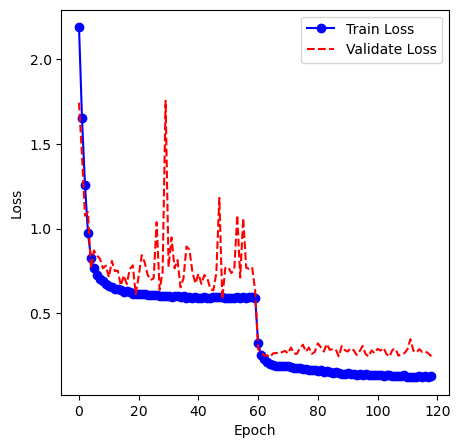

 60%|████████████████████████████████████████████                              | 119/200 [14:14:48<9:42:24, 431.41s/it]

Epoch:119
Time:14:21:36.747033
Loss:0.30140544097430216
Total:10000  Correct:9071  CleanAccuracy:0.9071


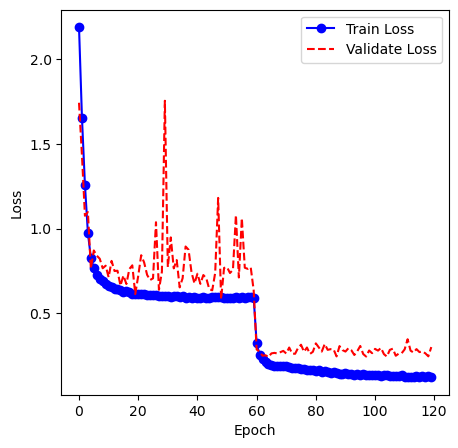

 60%|████████████████████████████████████████████▍                             | 120/200 [14:21:59<9:35:18, 431.49s/it]

Epoch:120
Time:14:28:50.754197
Loss:0.17760496023341643
Total:10000  Correct:9452  CleanAccuracy:0.9452


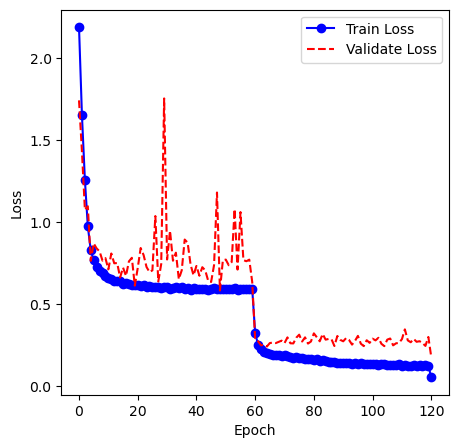

 60%|████████████████████████████████████████████▊                             | 121/200 [14:29:13<9:28:59, 432.14s/it]

Epoch:121
Time:14:36:06.088789
Loss:0.17219881162370224
Total:10000  Correct:9467  CleanAccuracy:0.9467


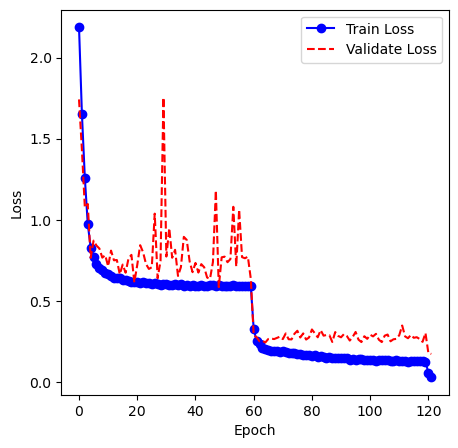

 61%|█████████████████████████████████████████████▏                            | 122/200 [14:36:26<9:22:06, 432.39s/it]

Epoch:122
Time:14:43:16.083177
Loss:0.1698268020444493
Total:10000  Correct:9492  CleanAccuracy:0.9492


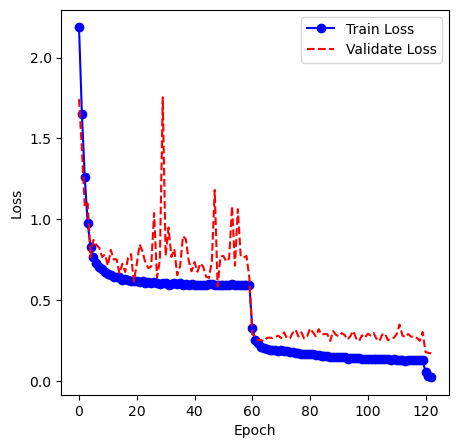

 62%|█████████████████████████████████████████████▌                            | 123/200 [14:43:40<9:15:19, 432.71s/it]

Epoch:123
Time:14:50:33.098718
Loss:0.1691523629870004
Total:10000  Correct:9497  CleanAccuracy:0.9497


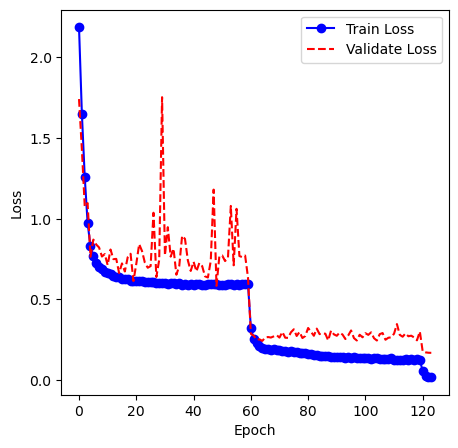

 62%|█████████████████████████████████████████████▉                            | 124/200 [14:50:55<9:09:19, 433.67s/it]

Epoch:124
Time:14:57:42.768178
Loss:0.16932023651213549
Total:10000  Correct:9505  CleanAccuracy:0.9505


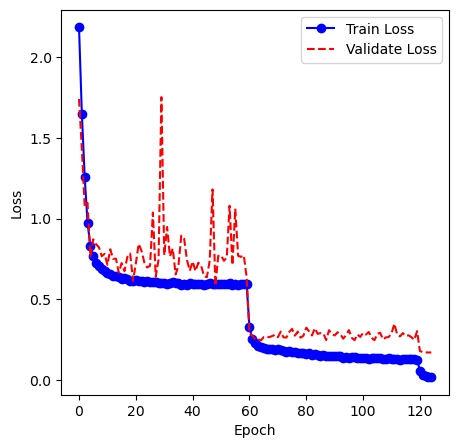

 62%|██████████████████████████████████████████████▎                           | 125/200 [14:58:07<9:01:16, 433.02s/it]

Epoch:125
Time:15:04:58.237756
Loss:0.1692796595537434
Total:10000  Correct:9506  CleanAccuracy:0.9506


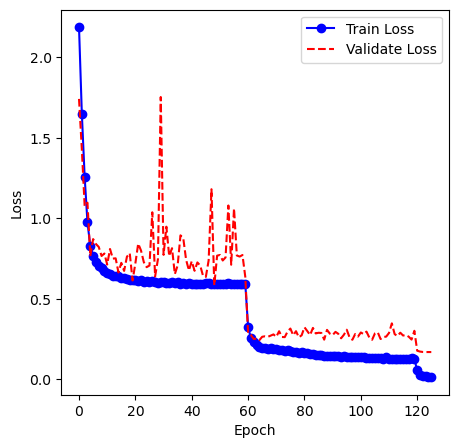

 63%|██████████████████████████████████████████████▌                           | 126/200 [15:05:26<8:56:21, 434.89s/it]

Epoch:126
Time:15:12:17.557293
Loss:0.16842936678806664
Total:10000  Correct:9513  CleanAccuracy:0.9513


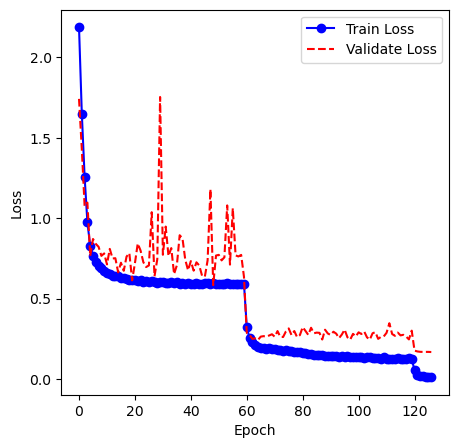

 64%|██████████████████████████████████████████████▉                           | 127/200 [15:12:40<8:48:40, 434.53s/it]

Epoch:127
Time:15:19:30.039309
Loss:0.16958224464990065
Total:10000  Correct:9518  CleanAccuracy:0.9518


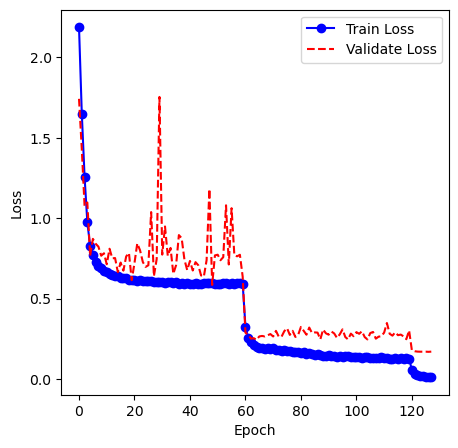

 64%|███████████████████████████████████████████████▎                          | 128/200 [15:19:55<8:41:36, 434.67s/it]

Epoch:128
Time:15:26:45.877893
Loss:0.16889022996730227
Total:10000  Correct:9531  CleanAccuracy:0.9531


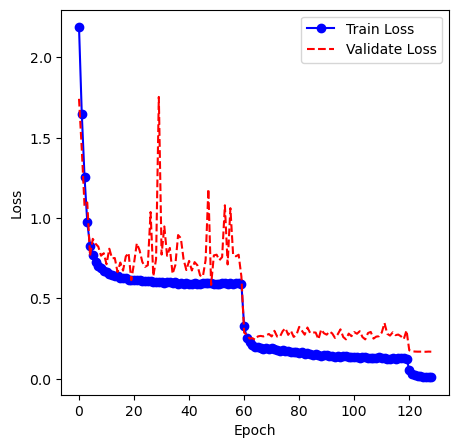

 64%|███████████████████████████████████████████████▋                          | 129/200 [15:27:12<8:35:07, 435.31s/it]

Epoch:129
Time:15:33:59.273583
Loss:0.1707936436921275
Total:10000  Correct:9516  CleanAccuracy:0.9516


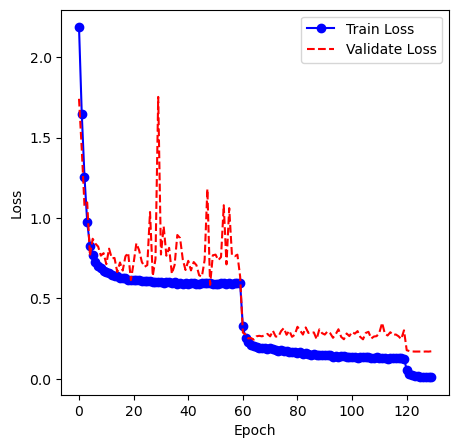

 65%|████████████████████████████████████████████████                          | 130/200 [15:34:31<8:29:13, 436.49s/it]

Epoch:130
Time:15:41:21.703409
Loss:0.1658234283487616
Total:10000  Correct:9526  CleanAccuracy:0.9526


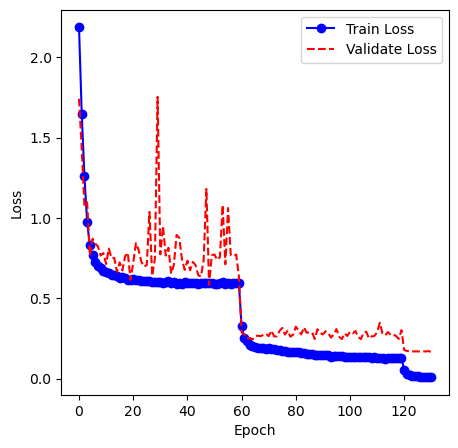

 66%|████████████████████████████████████████████████▍                         | 131/200 [15:41:48<8:22:04, 436.58s/it]

Epoch:131
Time:15:48:32.760136
Loss:0.16719698617147422
Total:10000  Correct:9522  CleanAccuracy:0.9522


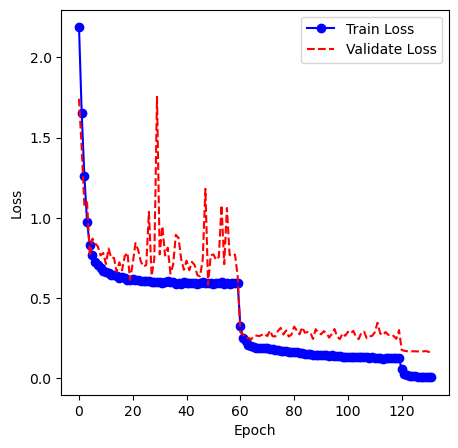

 66%|████████████████████████████████████████████████▊                         | 132/200 [15:48:52<8:10:37, 432.91s/it]

Epoch:132
Time:15:55:36.268490
Loss:0.16816573803037474
Total:10000  Correct:9529  CleanAccuracy:0.9529


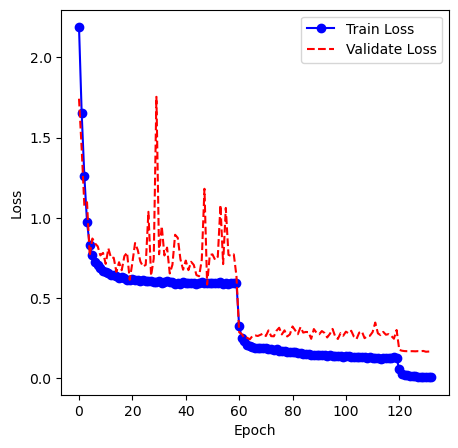

 66%|█████████████████████████████████████████████████▏                        | 133/200 [15:55:55<7:59:54, 429.77s/it]

Epoch:133
Time:16:02:40.696039
Loss:0.16699418456411919
Total:10000  Correct:9527  CleanAccuracy:0.9527


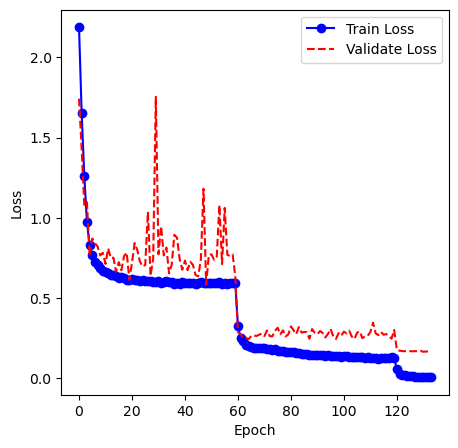

 67%|█████████████████████████████████████████████████▌                        | 134/200 [16:02:59<7:51:03, 428.24s/it]

Epoch:134
Time:16:09:44.677579
Loss:0.1687037833245135
Total:10000  Correct:9535  CleanAccuracy:0.9535


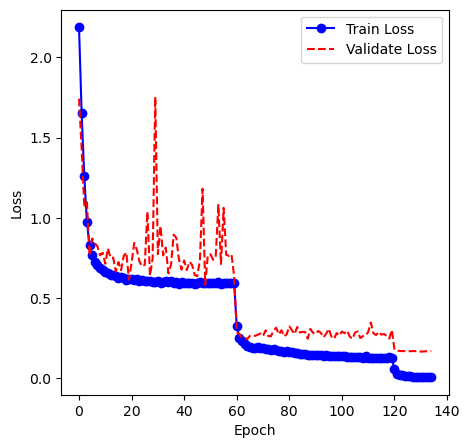

 68%|█████████████████████████████████████████████████▉                        | 135/200 [16:10:13<7:45:52, 430.03s/it]

Epoch:135
Time:16:17:06.158560
Loss:0.17109449516404227
Total:10000  Correct:9535  CleanAccuracy:0.9535


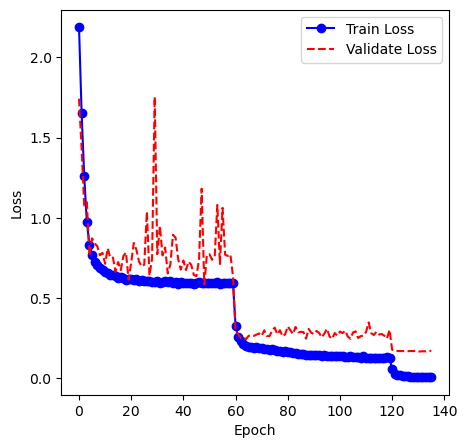

 68%|██████████████████████████████████████████████████▎                       | 136/200 [16:17:28<7:40:11, 431.42s/it]

Epoch:136
Time:16:24:12.656705
Loss:0.170931022167548
Total:10000  Correct:9524  CleanAccuracy:0.9524


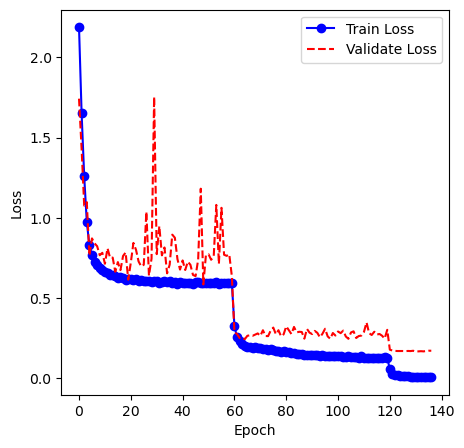

 68%|██████████████████████████████████████████████████▋                       | 137/200 [16:24:33<7:30:56, 429.48s/it]

Epoch:137
Time:16:31:24.532473
Loss:0.1687940374747984
Total:10000  Correct:9541  CleanAccuracy:0.9541


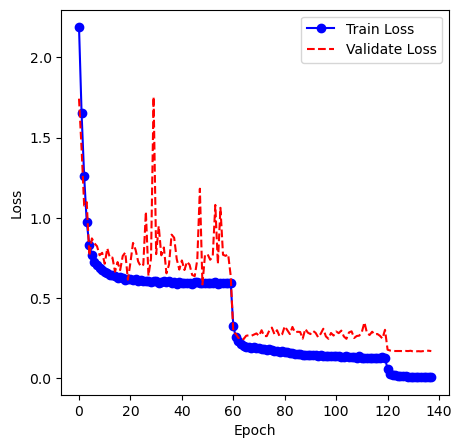

 69%|███████████████████████████████████████████████████                       | 138/200 [16:31:43<7:24:04, 429.74s/it]

Epoch:138
Time:16:38:30.989069
Loss:0.1658864190453104
Total:10000  Correct:9527  CleanAccuracy:0.9527


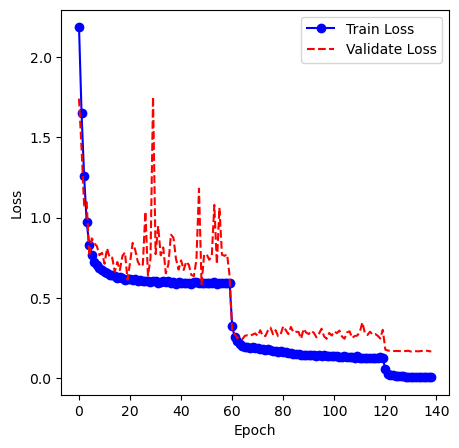

 70%|███████████████████████████████████████████████████▍                      | 139/200 [16:38:54<7:17:08, 429.97s/it]

Epoch:139
Time:16:45:46.640805
Loss:0.1680654504514201
Total:10000  Correct:9521  CleanAccuracy:0.9521


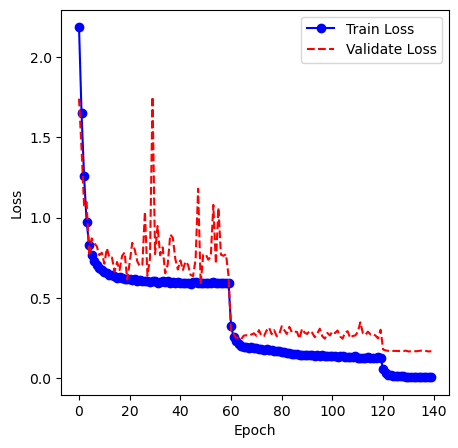

 70%|███████████████████████████████████████████████████▊                      | 140/200 [16:46:15<7:13:26, 433.44s/it]

Epoch:140
Time:16:53:02.674374
Loss:0.16883407140350767
Total:10000  Correct:9531  CleanAccuracy:0.9531


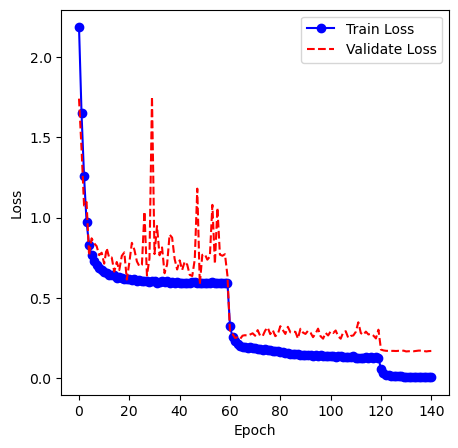

 70%|████████████████████████████████████████████████████▏                     | 141/200 [16:53:26<7:05:16, 432.49s/it]

Epoch:141
Time:17:00:15.420395
Loss:0.16747666140028927
Total:10000  Correct:9537  CleanAccuracy:0.9537


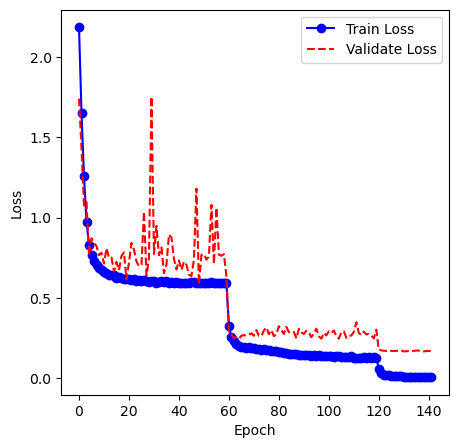

 71%|████████████████████████████████████████████████████▌                     | 142/200 [17:00:42<6:59:12, 433.67s/it]

Epoch:142
Time:17:07:28.633721
Loss:0.1684111325970714
Total:10000  Correct:9551  CleanAccuracy:0.9551


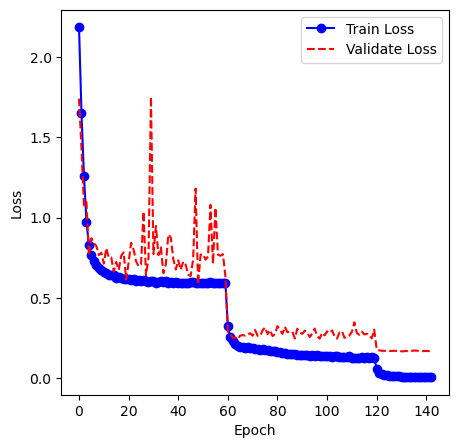

 72%|████████████████████████████████████████████████████▉                     | 143/200 [17:07:49<6:50:02, 431.62s/it]

Epoch:143
Time:17:14:42.642428
Loss:0.16762947164417896
Total:10000  Correct:9543  CleanAccuracy:0.9543


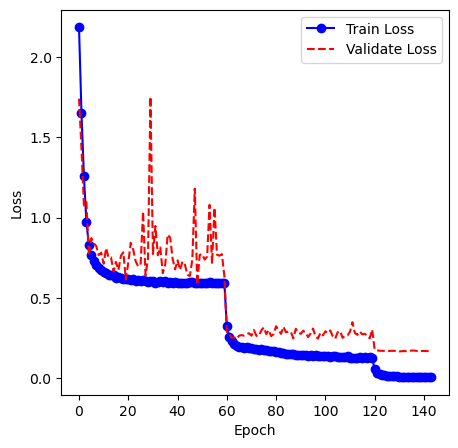

 72%|█████████████████████████████████████████████████████▎                    | 144/200 [17:15:05<6:44:09, 433.03s/it]

Epoch:144
Time:17:21:57.734482
Loss:0.16590069313965047
Total:10000  Correct:9554  CleanAccuracy:0.9554


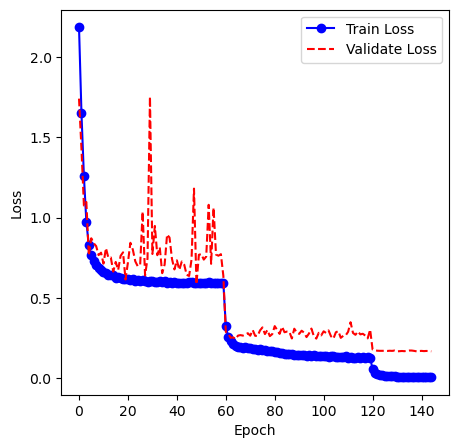

 72%|█████████████████████████████████████████████████████▋                    | 145/200 [17:22:27<6:39:20, 435.64s/it]

Epoch:145
Time:17:29:20.781696
Loss:0.17187591122326473
Total:10000  Correct:9538  CleanAccuracy:0.9538


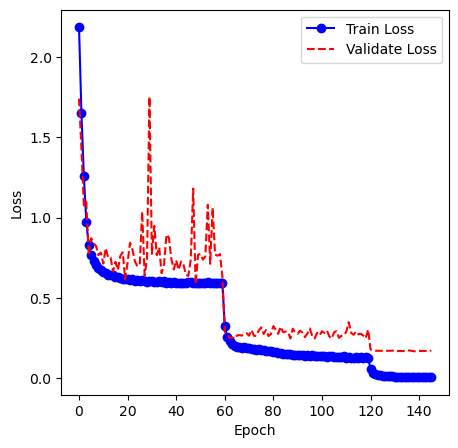

 73%|██████████████████████████████████████████████████████                    | 146/200 [17:29:46<6:32:57, 436.62s/it]

Epoch:146
Time:17:36:38.901262
Loss:0.17202258257564684
Total:10000  Correct:9537  CleanAccuracy:0.9537


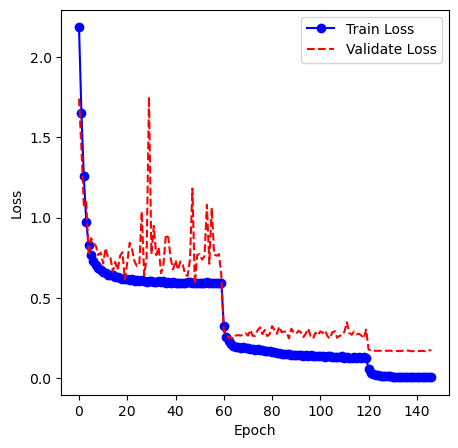

 74%|██████████████████████████████████████████████████████▍                   | 147/200 [17:37:05<6:26:21, 437.39s/it]

Epoch:147
Time:17:43:57.855146
Loss:0.17493104625485106
Total:10000  Correct:9540  CleanAccuracy:0.9540


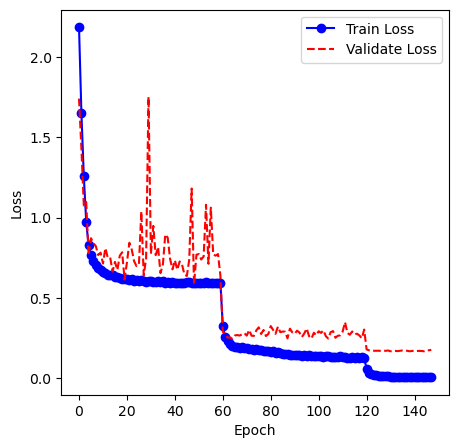

 74%|██████████████████████████████████████████████████████▊                   | 148/200 [17:44:21<6:18:48, 437.09s/it]

Epoch:148
Time:17:51:10.213011
Loss:0.17104959639533907
Total:10000  Correct:9554  CleanAccuracy:0.9554


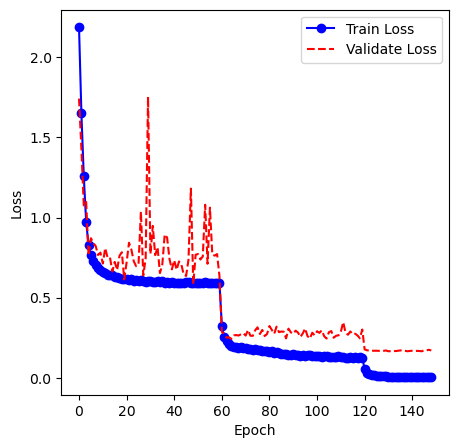

 74%|███████████████████████████████████████████████████████▏                  | 149/200 [17:51:34<6:10:27, 435.83s/it]

Epoch:149
Time:17:58:20.106948
Loss:0.175349428301146
Total:10000  Correct:9539  CleanAccuracy:0.9539


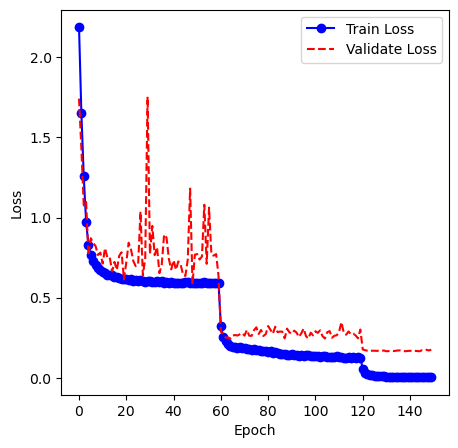

 75%|███████████████████████████████████████████████████████▌                  | 150/200 [17:58:46<6:02:03, 434.47s/it]

Epoch:150
Time:18:05:40.113233
Loss:0.1775147138491121
Total:10000  Correct:9539  CleanAccuracy:0.9539


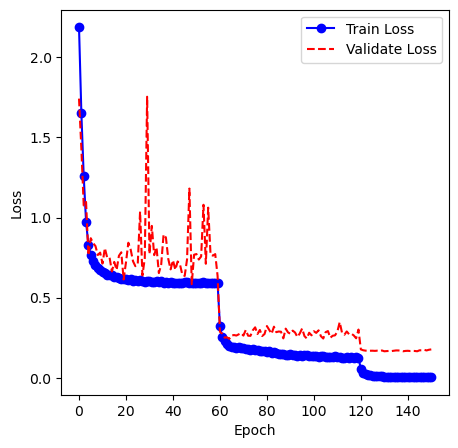

 76%|███████████████████████████████████████████████████████▊                  | 151/200 [18:06:06<5:56:09, 436.11s/it]

Epoch:151
Time:18:13:03.726992
Loss:0.17459748857081853
Total:10000  Correct:9528  CleanAccuracy:0.9528


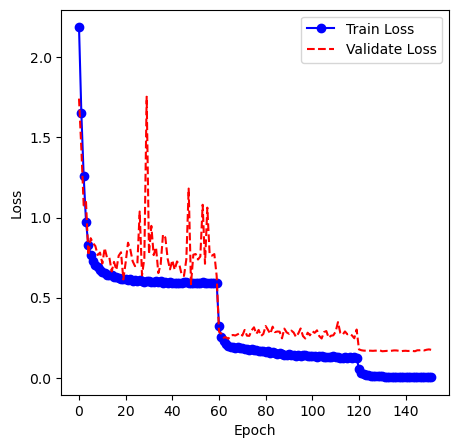

 76%|████████████████████████████████████████████████████████▏                 | 152/200 [18:13:26<5:50:00, 437.50s/it]

Epoch:152
Time:18:20:15.595822
Loss:0.17800001531207826
Total:10000  Correct:9530  CleanAccuracy:0.9530


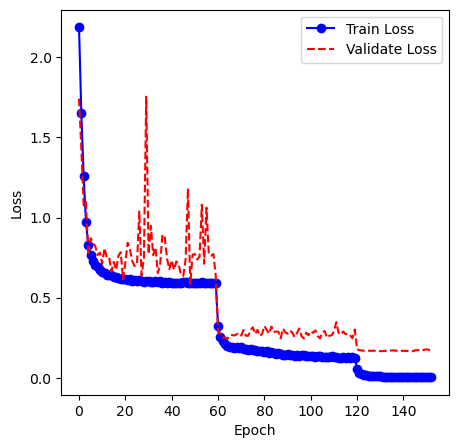

 76%|████████████████████████████████████████████████████████▌                 | 153/200 [18:20:34<5:40:30, 434.70s/it]

Epoch:153
Time:18:27:23.514118
Loss:0.17217108707212228
Total:10000  Correct:9540  CleanAccuracy:0.9540


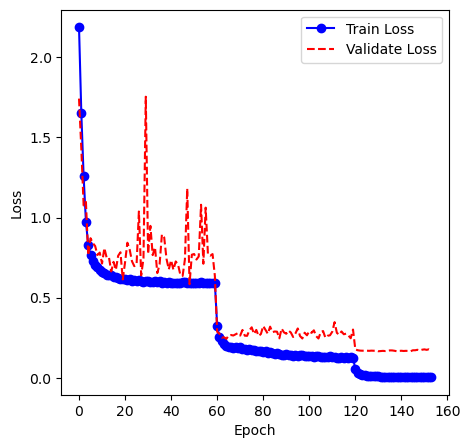

 77%|████████████████████████████████████████████████████████▉                 | 154/200 [18:27:43<5:31:54, 432.93s/it]

Epoch:154
Time:18:34:32.401644
Loss:0.17591593387830903
Total:10000  Correct:9531  CleanAccuracy:0.9531


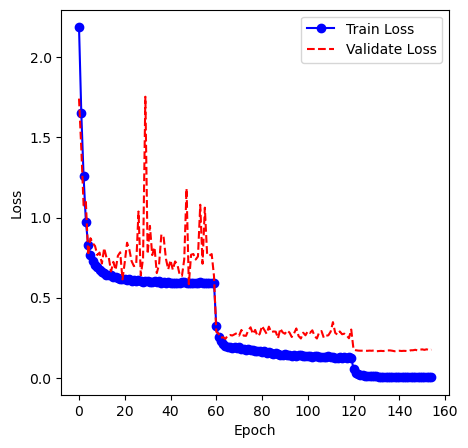

 78%|█████████████████████████████████████████████████████████▎                | 155/200 [18:34:52<5:23:48, 431.75s/it]

Epoch:155
Time:18:41:38.774938
Loss:0.1685176526397889
Total:10000  Correct:9547  CleanAccuracy:0.9547


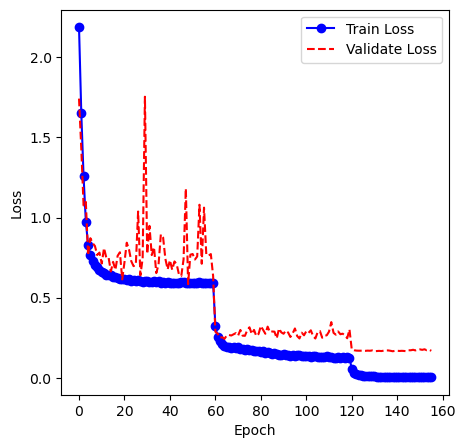

 78%|█████████████████████████████████████████████████████████▋                | 156/200 [18:42:03<5:16:21, 431.39s/it]

Epoch:156
Time:18:48:55.835860
Loss:0.1773139955540085
Total:10000  Correct:9542  CleanAccuracy:0.9542


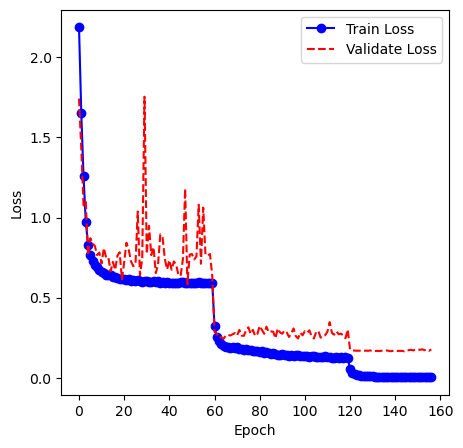

 78%|██████████████████████████████████████████████████████████                | 157/200 [18:49:16<5:09:35, 431.98s/it]

Epoch:157
Time:18:56:15.216149
Loss:0.1785294235817502
Total:10000  Correct:9541  CleanAccuracy:0.9541


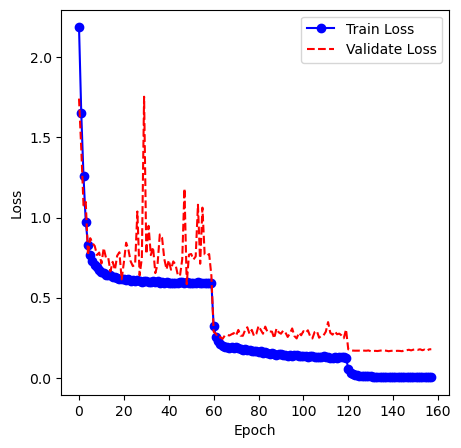

 79%|██████████████████████████████████████████████████████████▍               | 158/200 [18:56:52<5:07:22, 439.10s/it]

Epoch:158
Time:19:04:05.177284
Loss:0.17384968561803946
Total:10000  Correct:9541  CleanAccuracy:0.9541


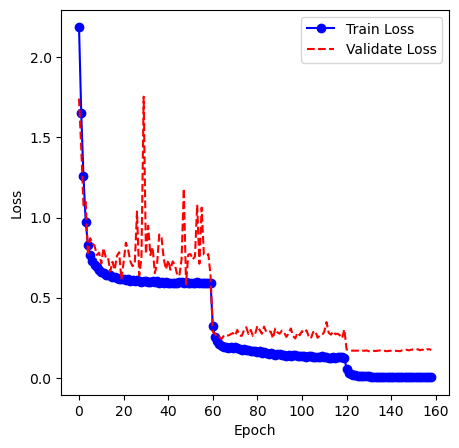

 80%|██████████████████████████████████████████████████████████▊               | 159/200 [19:04:33<5:04:34, 445.72s/it]

Epoch:159
Time:19:11:53.833752
Loss:0.17270522394731563
Total:10000  Correct:9553  CleanAccuracy:0.9553


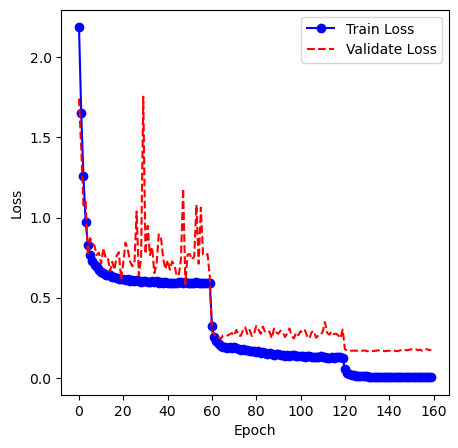

 80%|███████████████████████████████████████████████████████████▏              | 160/200 [19:12:22<5:01:44, 452.60s/it]

Epoch:160
Time:19:19:42.630159
Loss:0.17700856380456964
Total:10000  Correct:9557  CleanAccuracy:0.9557


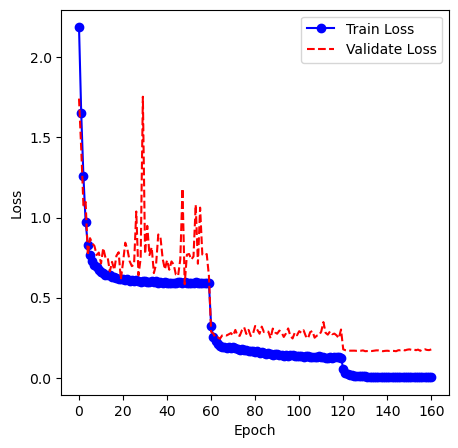

 80%|███████████████████████████████████████████████████████████▌              | 161/200 [19:20:14<4:58:00, 458.48s/it]

Epoch:161
Time:19:27:31.770569
Loss:0.1790087537742562
Total:10000  Correct:9534  CleanAccuracy:0.9534


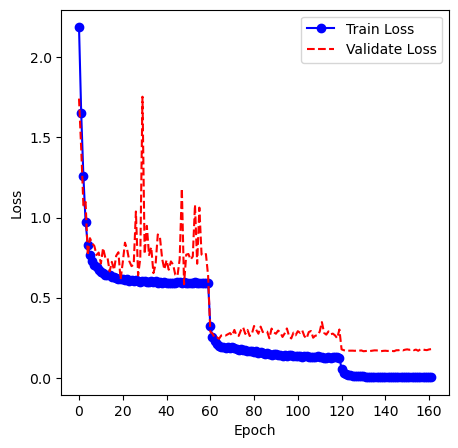

 81%|███████████████████████████████████████████████████████████▉              | 162/200 [19:28:03<4:52:18, 461.54s/it]

Epoch:162
Time:19:35:14.915215
Loss:0.17409571275277178
Total:10000  Correct:9547  CleanAccuracy:0.9547


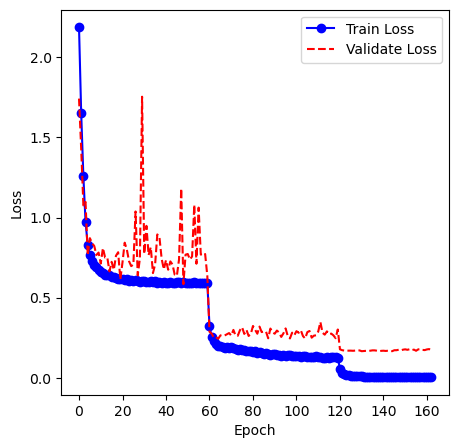

 82%|████████████████████████████████████████████████████████████▎             | 163/200 [19:35:42<4:44:14, 460.94s/it]

Epoch:163
Time:19:42:52.299812
Loss:0.17449817392817393
Total:10000  Correct:9539  CleanAccuracy:0.9539


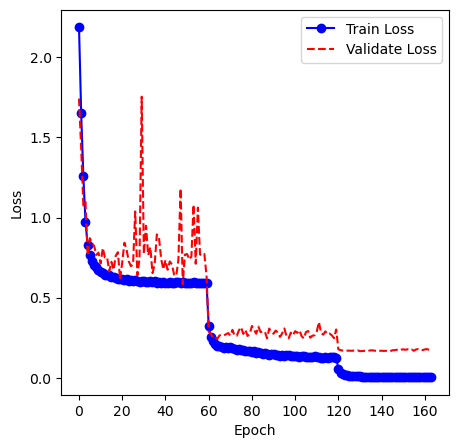

 82%|████████████████████████████████████████████████████████████▋             | 164/200 [19:43:27<4:37:17, 462.15s/it]

Epoch:164
Time:19:50:36.269049
Loss:0.1683839068161517
Total:10000  Correct:9557  CleanAccuracy:0.9557


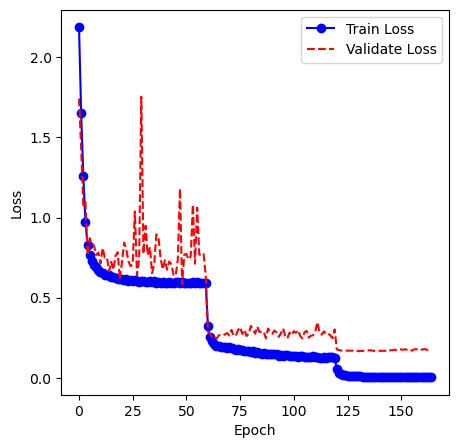

 82%|█████████████████████████████████████████████████████████████             | 165/200 [19:51:01<4:28:11, 459.75s/it]

Epoch:165
Time:19:58:18.648527
Loss:0.17350611262158833
Total:10000  Correct:9546  CleanAccuracy:0.9546


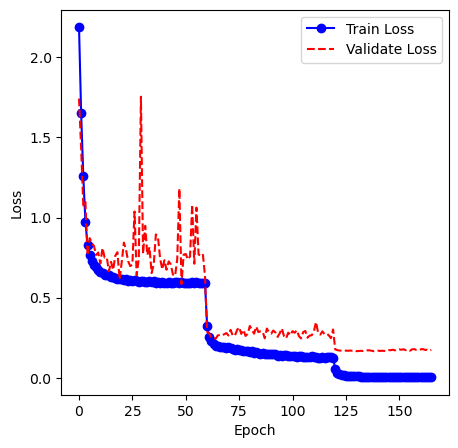

 83%|█████████████████████████████████████████████████████████████▍            | 166/200 [19:58:54<4:22:42, 463.60s/it]

Epoch:166
Time:20:06:04.357609
Loss:0.1825206370298236
Total:10000  Correct:9544  CleanAccuracy:0.9544


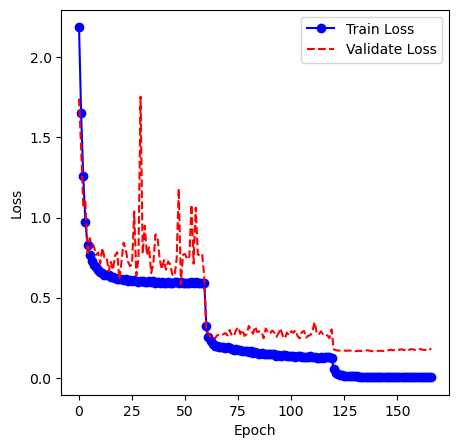

 84%|█████████████████████████████████████████████████████████████▊            | 167/200 [20:06:25<4:12:52, 459.78s/it]

Epoch:167
Time:20:13:34.588842
Loss:0.17993267410908625
Total:10000  Correct:9543  CleanAccuracy:0.9543


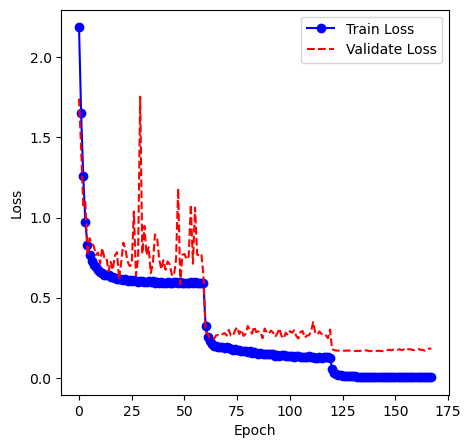

 84%|██████████████████████████████████████████████████████████████▏           | 168/200 [20:14:02<4:04:51, 459.10s/it]

Epoch:168
Time:20:21:02.410743
Loss:0.18232802683658625
Total:10000  Correct:9535  CleanAccuracy:0.9535


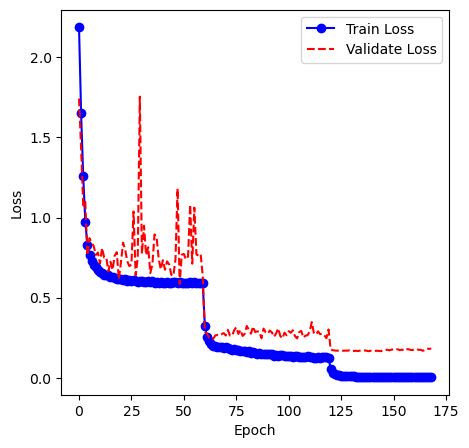

 84%|██████████████████████████████████████████████████████████████▌           | 169/200 [20:21:23<3:54:22, 453.62s/it]

Epoch:169
Time:20:28:32.517827
Loss:0.17885010663257056
Total:10000  Correct:9531  CleanAccuracy:0.9531


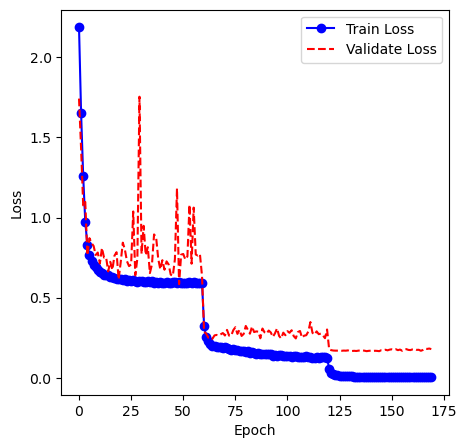

 85%|██████████████████████████████████████████████████████████████▉           | 170/200 [20:29:05<3:48:06, 456.21s/it]

Epoch:170
Time:20:36:10.868459
Loss:0.17639848372743527
Total:10000  Correct:9535  CleanAccuracy:0.9535


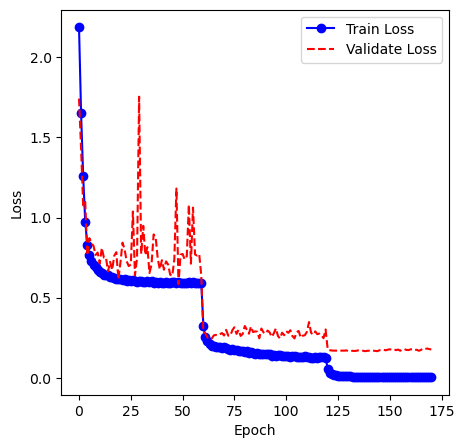

 86%|███████████████████████████████████████████████████████████████▎          | 171/200 [20:36:34<3:39:24, 453.96s/it]

Epoch:171
Time:20:44:35.667615
Loss:0.1735759328354519
Total:10000  Correct:9552  CleanAccuracy:0.9552


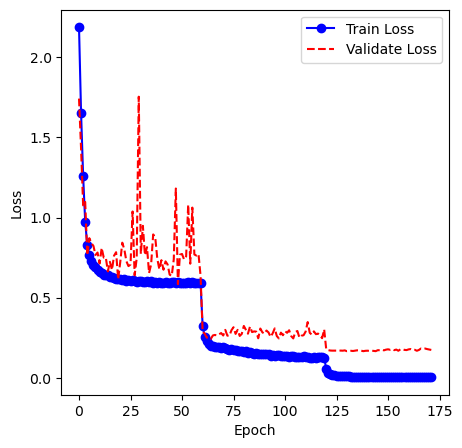

 86%|███████████████████████████████████████████████████████████████▋          | 172/200 [20:45:23<3:42:17, 476.34s/it]

Epoch:172
Time:20:53:35.780054
Loss:0.1766876435324255
Total:10000  Correct:9543  CleanAccuracy:0.9543


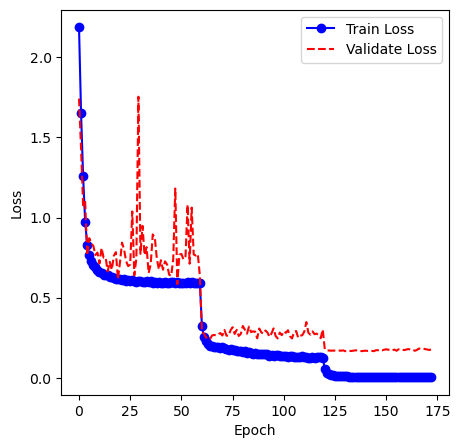

 86%|████████████████████████████████████████████████████████████████          | 173/200 [20:54:23<3:42:59, 495.53s/it]

Epoch:173
Time:21:02:41.537948
Loss:0.17585101850444643
Total:10000  Correct:9538  CleanAccuracy:0.9538


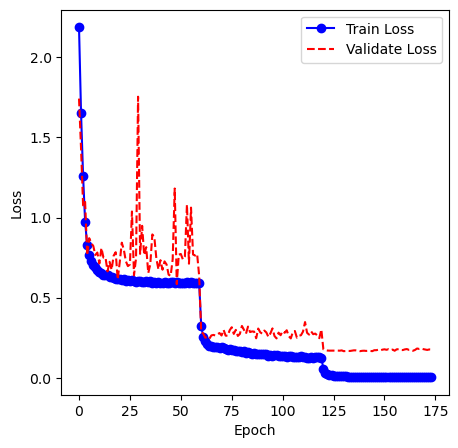

 87%|████████████████████████████████████████████████████████████████▍         | 174/200 [21:03:04<3:38:06, 503.33s/it]

Epoch:174
Time:21:11:04.868183
Loss:0.1728805593721131
Total:10000  Correct:9537  CleanAccuracy:0.9537


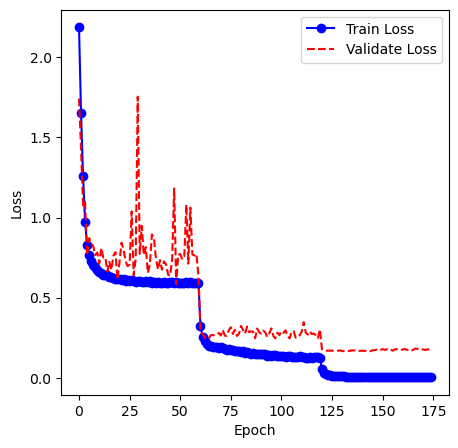

 88%|████████████████████████████████████████████████████████████████▊         | 175/200 [21:11:29<3:29:49, 503.58s/it]

Epoch:175
Time:21:19:27.893533
Loss:0.17577764807702653
Total:10000  Correct:9545  CleanAccuracy:0.9545


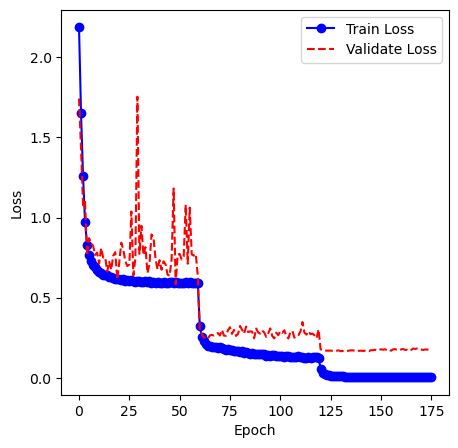

 88%|█████████████████████████████████████████████████████████████████         | 176/200 [21:19:47<3:20:45, 501.90s/it]

Epoch:176
Time:21:27:32.565230
Loss:0.17579983785906925
Total:10000  Correct:9548  CleanAccuracy:0.9548


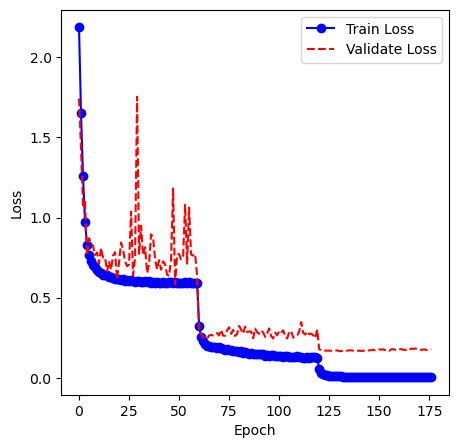

 88%|█████████████████████████████████████████████████████████████████▍        | 177/200 [21:28:01<3:11:33, 499.71s/it]

Epoch:177
Time:21:35:57.735975
Loss:0.17885229709601333
Total:10000  Correct:9547  CleanAccuracy:0.9547


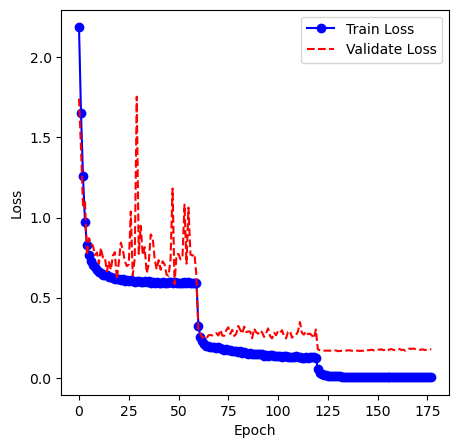

 89%|█████████████████████████████████████████████████████████████████▊        | 178/200 [21:36:36<3:04:55, 504.34s/it]

Epoch:178
Time:21:44:34.692462
Loss:0.1808031886549534
Total:10000  Correct:9533  CleanAccuracy:0.9533


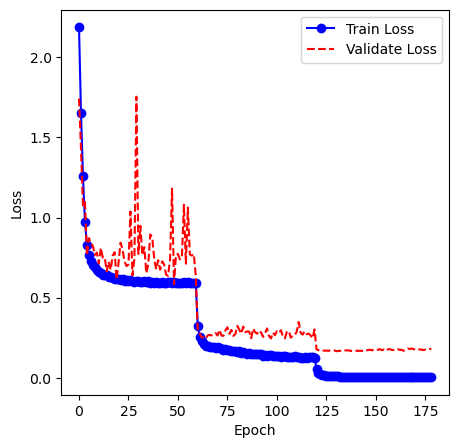

 90%|██████████████████████████████████████████████████████████████████▏       | 179/200 [21:45:23<2:58:53, 511.11s/it]

Epoch:179
Time:21:53:25.341971
Loss:0.18105340626008196
Total:10000  Correct:9538  CleanAccuracy:0.9538


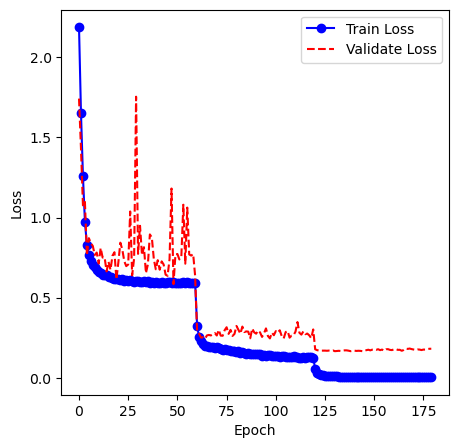

 90%|██████████████████████████████████████████████████████████████████▌       | 180/200 [21:54:14<2:52:22, 517.14s/it]

Epoch:180
Time:22:02:34.601086
Loss:0.17619838638803192
Total:10000  Correct:9561  CleanAccuracy:0.9561


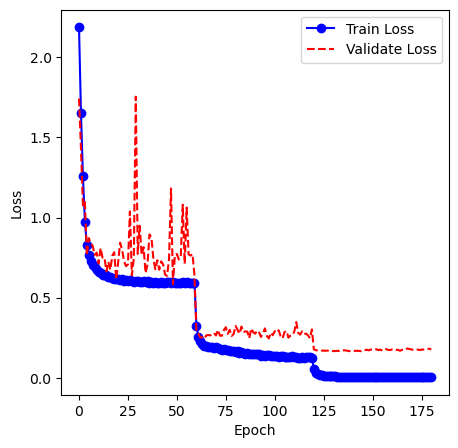

 90%|██████████████████████████████████████████████████████████████████▉       | 181/200 [22:03:24<2:46:53, 527.01s/it]

Epoch:181
Time:22:11:32.678971
Loss:0.17515372577403782
Total:10000  Correct:9548  CleanAccuracy:0.9548


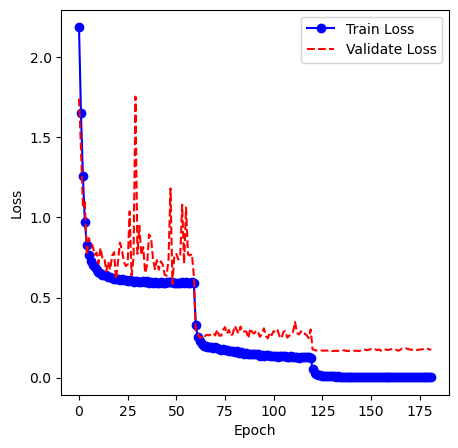

 91%|███████████████████████████████████████████████████████████████████▎      | 182/200 [22:12:23<2:39:08, 530.50s/it]

Epoch:182
Time:22:20:39.860690
Loss:0.17499381817427997
Total:10000  Correct:9555  CleanAccuracy:0.9555


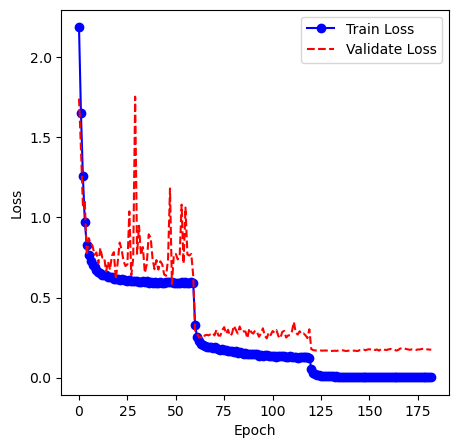

 92%|███████████████████████████████████████████████████████████████████▋      | 183/200 [22:21:33<2:31:57, 536.34s/it]

Epoch:183
Time:22:29:51.069722
Loss:0.1720880364492229
Total:10000  Correct:9564  CleanAccuracy:0.9564


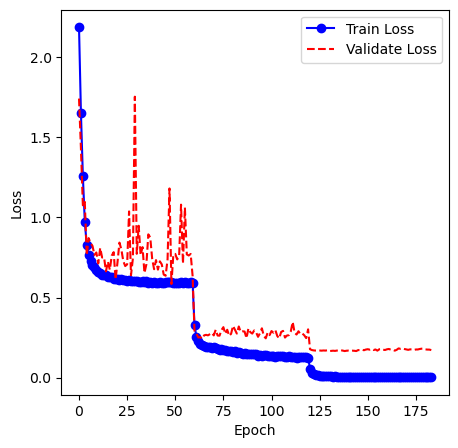

 92%|████████████████████████████████████████████████████████████████████      | 184/200 [22:30:40<2:23:53, 539.61s/it]

Epoch:184
Time:22:39:07.084381
Loss:0.17283656969465636
Total:10000  Correct:9553  CleanAccuracy:0.9553


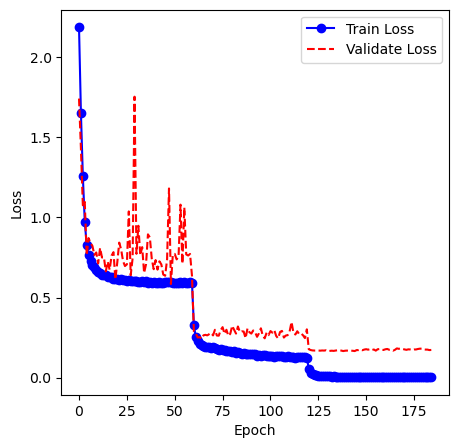

 92%|████████████████████████████████████████████████████████████████████▍     | 185/200 [22:39:55<2:16:04, 544.28s/it]

Epoch:185
Time:22:48:15.653851
Loss:0.17345998305812502
Total:10000  Correct:9569  CleanAccuracy:0.9569


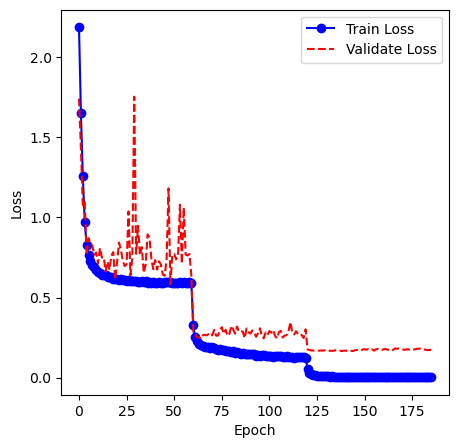

 93%|████████████████████████████████████████████████████████████████████▊     | 186/200 [22:49:02<2:07:11, 545.08s/it]

Epoch:186
Time:22:57:23.156085
Loss:0.1729369293070791
Total:10000  Correct:9559  CleanAccuracy:0.9559


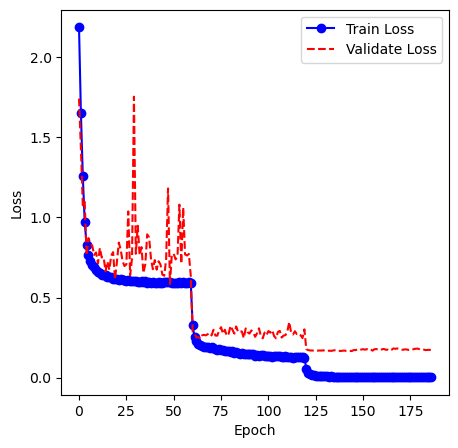

 94%|█████████████████████████████████████████████████████████████████████▏    | 187/200 [22:58:04<1:57:52, 544.04s/it]

Epoch:187
Time:23:06:21.329156
Loss:0.16998854809356614
Total:10000  Correct:9564  CleanAccuracy:0.9564


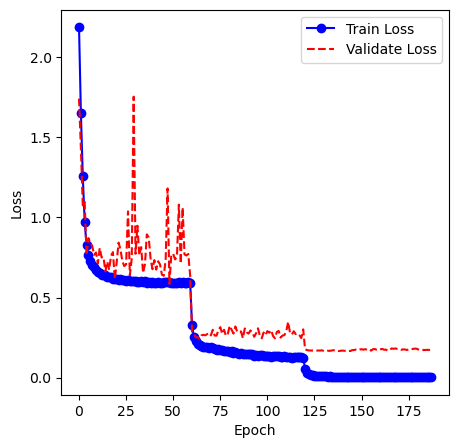

 94%|█████████████████████████████████████████████████████████████████████▌    | 188/200 [23:06:54<1:47:59, 539.95s/it]

Epoch:188
Time:23:15:05.082161
Loss:0.17069825333057376
Total:10000  Correct:9566  CleanAccuracy:0.9566


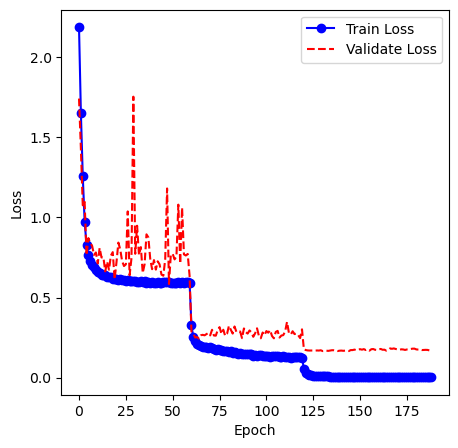

 94%|█████████████████████████████████████████████████████████████████████▉    | 189/200 [23:15:40<1:38:10, 535.48s/it]

Epoch:189
Time:23:23:58.357497
Loss:0.1725122404415696
Total:10000  Correct:9571  CleanAccuracy:0.9571


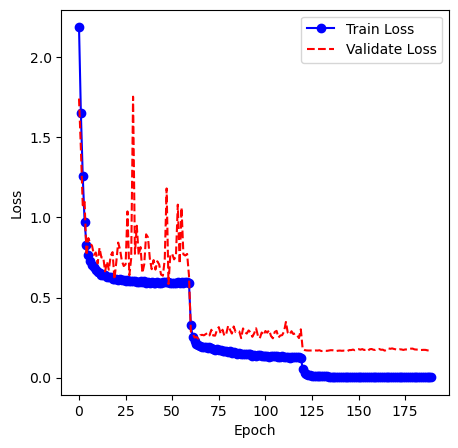

 95%|██████████████████████████████████████████████████████████████████████▎   | 190/200 [23:24:20<1:28:30, 531.02s/it]

Epoch:190
Time:23:32:35.702873
Loss:0.17279790937562084
Total:10000  Correct:9564  CleanAccuracy:0.9564


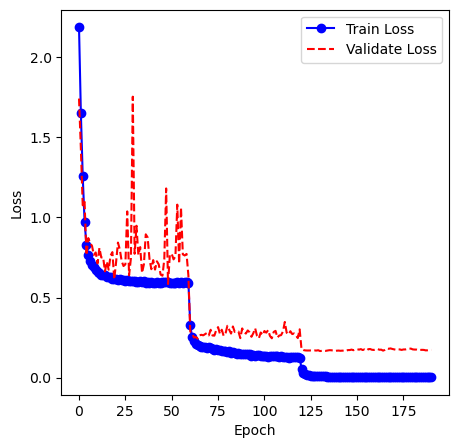

 96%|██████████████████████████████████████████████████████████████████████▋   | 191/200 [23:33:00<1:19:10, 527.80s/it]

Epoch:191
Time:23:41:17.664194
Loss:0.17157940510638095
Total:10000  Correct:9577  CleanAccuracy:0.9577


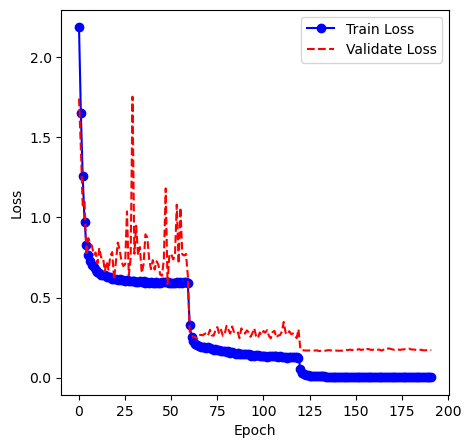

 96%|███████████████████████████████████████████████████████████████████████   | 192/200 [23:41:44<1:10:11, 526.46s/it]

Epoch:192
Time:23:49:57.399619
Loss:0.17178014431551572
Total:10000  Correct:9572  CleanAccuracy:0.9572


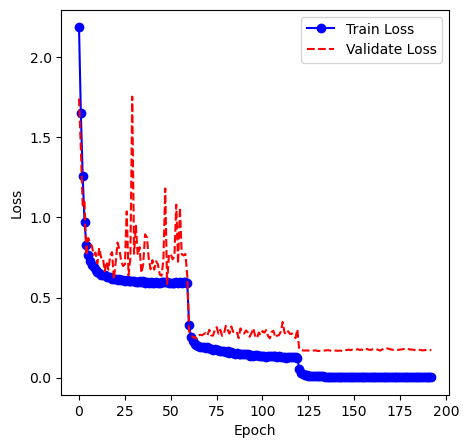

 96%|███████████████████████████████████████████████████████████████████████▍  | 193/200 [23:50:26<1:01:16, 525.18s/it]

Epoch:193
Time:23:58:23.486147
Loss:0.17102436677101976
Total:10000  Correct:9569  CleanAccuracy:0.9569


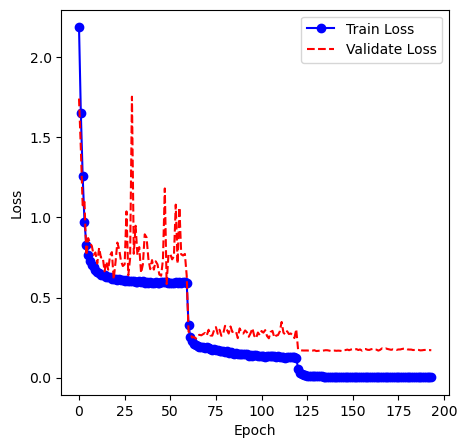

 97%|█████████████████████████████████████████████████████████████████████████▋  | 194/200 [23:58:41<51:37, 516.19s/it]

Epoch:194
Time:1 day, 0:06:53.228571
Loss:0.17193828835109318
Total:10000  Correct:9566  CleanAccuracy:0.9566


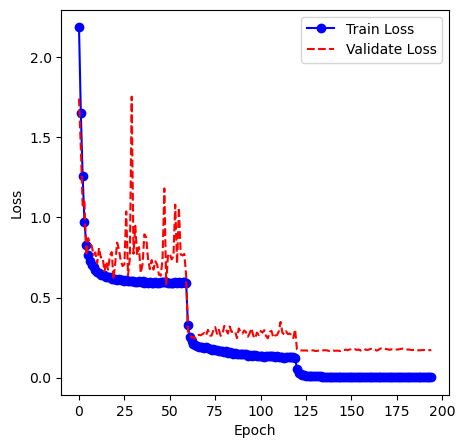

 98%|██████████████████████████████████████████████████████████████████████████  | 195/200 [24:07:17<42:59, 515.99s/it]

Epoch:195
Time:1 day, 0:15:28.217305
Loss:0.1732544017392739
Total:10000  Correct:9563  CleanAccuracy:0.9563


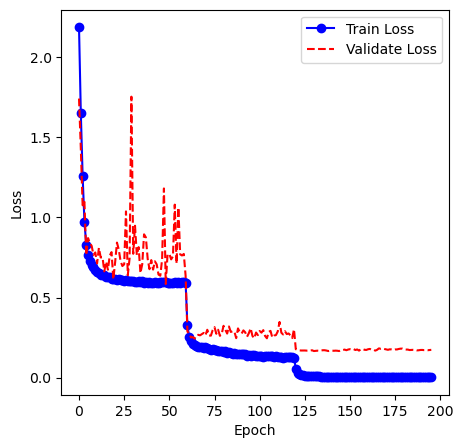

 98%|██████████████████████████████████████████████████████████████████████████▍ | 196/200 [24:16:09<34:43, 520.97s/it]

Epoch:196
Time:1 day, 0:24:22.838271
Loss:0.1722975254374796
Total:10000  Correct:9575  CleanAccuracy:0.9575


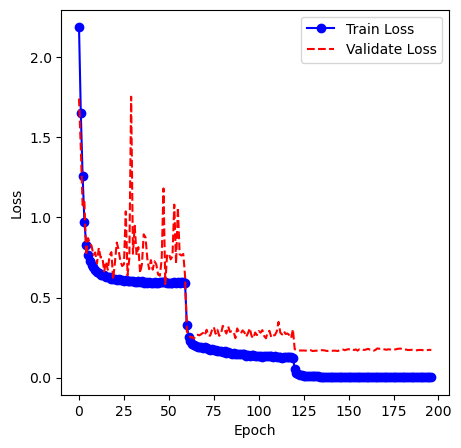

 98%|██████████████████████████████████████████████████████████████████████████▊ | 197/200 [24:25:11<26:21, 527.14s/it]

Epoch:197
Time:1 day, 0:33:29.652023
Loss:0.16994954016079722
Total:10000  Correct:9577  CleanAccuracy:0.9577


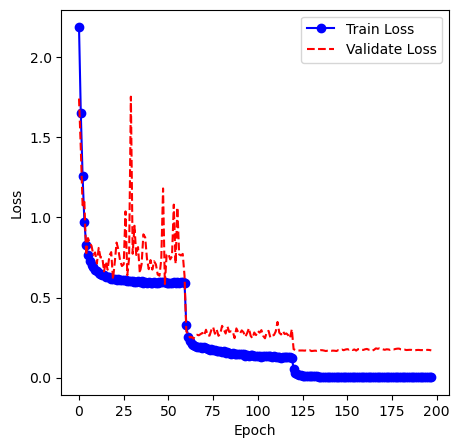

 99%|███████████████████████████████████████████████████████████████████████████▏| 198/200 [24:34:13<17:43, 531.54s/it]

Epoch:198
Time:1 day, 0:42:29.169733
Loss:0.17284086785564115
Total:10000  Correct:9569  CleanAccuracy:0.9569


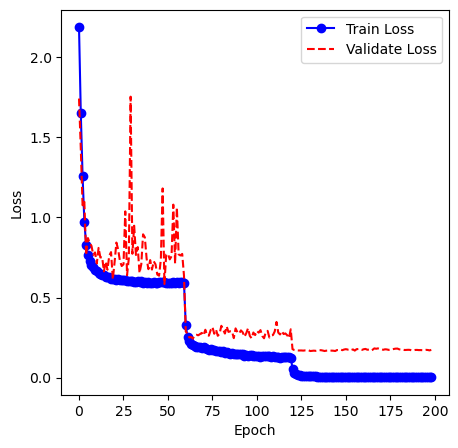

100%|███████████████████████████████████████████████████████████████████████████▌| 199/200 [24:43:11<08:53, 533.61s/it]

Epoch:199
Time:1 day, 0:51:34.744864
Loss:0.1741232645126787
Total:10000  Correct:9570  CleanAccuracy:0.9570


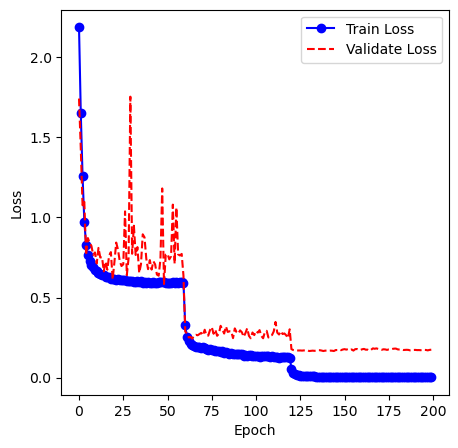

100%|████████████████████████████████████████████████████████████████████████████| 200/200 [24:52:14<00:00, 447.67s/it]


In [9]:
train(model_device=device,
      model=net,
      model_optimizer=optimizer, 
      train_set=train_loader, 
      validate_set=test_loader
)

In [10]:
torch.cuda.empty_cache()